
# Merge All Feature Tables into One `encounters` DataFrame

This notebook consolidates team-generated features from multiple modules — **observations, procedures, conditions, encounters, immunizations, medications** — into a single dataframe joined on **`Id`** using an **outer** join.

**What it does**
- Loads CSVs for each module (expects filenames below).
- Normalizes column names (uppercases by default), ensures the join key is **`Id`**.
- Adds per-source prefixes to avoid accidental column name collisions (configurable).
- Merges everything with an **outer** join on `Id` to keep all patients.
- Produces `encounters_merged` and saves to Parquet/CSV.

**Expected filenames (in `base_dir`)**
- `encounters.csv`
- `observations.csv`
- `procedures.csv`
- `conditions.csv`
- `immunizations.csv`
- `medications.csv`

> If your files live elsewhere or use different names, update the `PATHS` dict below.


In [6]:
# Mount Google Drive first so data saves permanently
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:

# === CONFIG ===
# Point this to the directory containing your CSVs.
base_dir = "/content/drive/MyDrive/Rerun/synthea_run/output/csv/"

# Where to write outputs
output_dir = "./_merged_outputs"
output_basename = "encounters_merged"

# Add source prefixes to non-key columns to avoid collisions
ADD_SOURCE_PREFIX = True

# Expected file names per module (edit as needed)
PATHS = {
    "encounters": f"{base_dir}/encounters.csv",
    "observations": f"{base_dir}/observations.csv",
    "procedures": f"{base_dir}/procedures.csv",
    "conditions": f"{base_dir}/conditions.csv",
    "immunizations": f"{base_dir}/immunizations.csv",
    "medications": f"{base_dir}/medications.csv",
    "patients": f"{base_dir}/patients.csv"
}

# Join settings
JOIN_KEY = "Id"     # user-specified
JOIN_HOW = "outer"  # user-specified


In [3]:
import pandas as pd

# Create a dictionary to hold the dataframes
loaded_dataframes = {}

# Iterate through the paths and read each CSV into a dataframe
for name, path in PATHS.items():
    try:
        df = pd.read_csv(path)
        loaded_dataframes[name] = df
        print(f"Successfully loaded '{name}' with shape: {df.shape}")
    except FileNotFoundError:
        print(f"Error: File not found at {path} for '{name}'")
    except Exception as e:
        print(f"An error occurred while reading {path} for '{name}': {e}")

# You can access the dataframes using the dictionary, e.g., loaded_dataframes['encounters']

Successfully loaded 'encounters' with shape: (1371885, 15)
Successfully loaded 'observations' with shape: (17690091, 9)
Successfully loaded 'procedures' with shape: (3805430, 10)
Successfully loaded 'conditions' with shape: (843894, 7)
Successfully loaded 'immunizations' with shape: (331181, 6)
Successfully loaded 'medications' with shape: (1181836, 13)
Successfully loaded 'patients' with shape: (23044, 28)


In [4]:
# Access the encounters and patients dataframes from the loaded_dataframes dictionary
encounters_df = loaded_dataframes['encounters']
encounters_df = encounters_df[encounters_df['ENCOUNTERCLASS'] == 'inpatient']
encounters_df.shape

(22617, 15)

In [5]:

patients_df = loaded_dataframes['patients']

# Perform a left join of encounters and patients
encounters_patients_merged = pd.merge(
    encounters_df,
    patients_df,
    left_on='PATIENT',
    right_on='Id',
    how='left'
)

# Rename the Id_x column to Encounter_Id
encounters_patients_merged = encounters_patients_merged.rename(columns={'Id_x': 'Encounter_Id'})


# Display the first few rows of the merged dataframe and its shape
print("Shape of the merged dataframe:", encounters_patients_merged.shape)
display(encounters_patients_merged.head())

Shape of the merged dataframe: (22617, 43)


,Encounter_Id,START,STOP,PATIENT,ORGANIZATION,PROVIDER,PAYER,ENCOUNTERCLASS,CODE,DESCRIPTION,...,CITY,STATE,COUNTY,FIPS,ZIP,LAT,LON,HEALTHCARE_EXPENSES,HEALTHCARE_COVERAGE,INCOME
0,1d82fac5-5e58-08c1-855a-2a52641b74d5,2011-03-10T15:14:40Z,2011-03-11T15:14:40Z,1d82fac5-5e58-08c1-30e1-013e34d50410,74ab949d-17ac-3309-83a0-13b4405c66aa,bb4836a0-4e45-3d29-a120-8dc655f46e9a,26aab0cd-6aba-3e1b-ac5b-05c8867e762c,inpatient,32485007,Hospital admission (procedure),...,Boston,Massachusetts,Suffolk County,25025.0,2121,42.325357,-71.042564,486254.89,462587.19,71512
1,1d82fac5-5e58-08c1-e1b9-864f776d8394,2011-03-12T21:51:44Z,2011-03-13T21:51:44Z,1d82fac5-5e58-08c1-30e1-013e34d50410,74ab949d-17ac-3309-83a0-13b4405c66aa,bb4836a0-4e45-3d29-a120-8dc655f46e9a,26aab0cd-6aba-3e1b-ac5b-05c8867e762c,inpatient,305342007,Admission to ward (procedure),...,Boston,Massachusetts,Suffolk County,25025.0,2121,42.325357,-71.042564,486254.89,462587.19,71512
2,1d82fac5-5e58-08c1-ae6b-841d0587ff1b,2023-09-04T17:02:55Z,2023-09-07T17:02:55Z,1d82fac5-5e58-08c1-30e1-013e34d50410,41e2a44c-477c-3511-96f9-12c476aa3b6a,e9386ed5-8633-3c13-ab8d-bb90827c8ba2,a735bf55-83e9-331a-899d-a82a60b9f60c,inpatient,308251003,Admission to clinical oncology department (pro...,...,Boston,Massachusetts,Suffolk County,25025.0,2121,42.325357,-71.042564,486254.89,462587.19,71512
3,1d82fac5-5e58-08c1-ba36-f73618eb10ff,2024-01-10T19:55:32Z,2024-01-30T15:36:20Z,1d82fac5-5e58-08c1-30e1-013e34d50410,41e2a44c-477c-3511-96f9-12c476aa3b6a,e9386ed5-8633-3c13-ab8d-bb90827c8ba2,a735bf55-83e9-331a-899d-a82a60b9f60c,inpatient,305432006,Admission to surgical transplant department (p...,...,Boston,Massachusetts,Suffolk County,25025.0,2121,42.325357,-71.042564,486254.89,462587.19,71512
4,a58bb45d-a3da-e389-31ce-50a30254be3d,1990-03-21T10:30:20Z,1990-03-22T10:30:20Z,a58bb45d-a3da-e389-8b7f-e8504f868fe3,c7542447-e06e-32cb-b6db-243c23a0dbc2,8058cbc5-7988-3bc8-a494-b125de3bedc9,e03e23c9-4df1-3eb6-a62d-f70f02301496,inpatient,305408004,Admission to surgical department (procedure),...,Brookline,Massachusetts,Norfolk County,25025.0,2215,42.347322,-71.143242,521790.50,128043.55,120150


In [8]:
procedures_df = loaded_dataframes['procedures'].copy()

In [9]:
import pandas as pd

# Ensure encounters_df is available from loaded_dataframes or a previous step
# If encounters_df was overwritten, we might need to reload it or use encounters_patients_merged
# For this task, we assume `encounters_df` from `loaded_dataframes` is the source of all encounter IDs.

# Get all unique encounter IDs from the encounters_df
# Note: If `encounters_df` was already filtered for 'inpatient' encounters earlier,
# this will use the IDs from the filtered set.
encounter_ids = encounters_df['Id'].unique()

# Filter procedures_df to keep only rows where the 'ENCOUNTER' ID is in the list of encounter_ids
procedures_filtered_df = procedures_df[procedures_df['ENCOUNTER'].isin(encounter_ids)].copy()

print(f"Original procedures_df shape: {procedures_df.shape}")
print(f"Filtered procedures_df shape: {procedures_filtered_df.shape}")

# Optionally, update procedures_df to be the filtered version
procedures_df = procedures_filtered_df

print("First 5 rows of the filtered procedures_df:")
display(procedures_df.head())

Original procedures_df shape: (3805430, 10)
Filtered procedures_df shape: (132564, 10)
First 5 rows of the filtered procedures_df:


,START,STOP,PATIENT,ENCOUNTER,SYSTEM,CODE,DESCRIPTION,BASE_COST,REASONCODE,REASONDESCRIPTION
311,2024-01-10T19:55:32Z,2024-01-10T21:51:34Z,1d82fac5-5e58-08c1-30e1-013e34d50410,1d82fac5-5e58-08c1-ba36-f73618eb10ff,SNOMED-CT,234336002,Hemopoietic stem cell transplant (procedure),431.4,6.983030e+08,Awaiting transplantation of bone marrow (situa...
312,2024-01-10T21:51:34Z,2024-01-10T22:40:06Z,1d82fac5-5e58-08c1-30e1-013e34d50410,1d82fac5-5e58-08c1-ba36-f73618eb10ff,SNOMED-CT,133899007,Postoperative care (regime/therapy),431.4,1.533510e+14,History of peripheral stem cell transplant (si...
313,2024-01-10T22:40:06Z,2024-01-10T22:50:14Z,1d82fac5-5e58-08c1-30e1-013e34d50410,1d82fac5-5e58-08c1-ba36-f73618eb10ff,SNOMED-CT,473220001,Hematologic disorder medication review (proced...,431.4,1.533510e+14,History of peripheral stem cell transplant (si...
314,2024-01-11T22:50:14Z,2024-01-11T23:36:36Z,1d82fac5-5e58-08c1-30e1-013e34d50410,1d82fac5-5e58-08c1-ba36-f73618eb10ff,SNOMED-CT,133899007,Postoperative care (regime/therapy),431.4,1.533510e+14,History of peripheral stem cell transplant (si...
315,2024-01-11T23:36:36Z,2024-01-11T23:49:58Z,1d82fac5-5e58-08c1-30e1-013e34d50410,1d82fac5-5e58-08c1-ba36-f73618eb10ff,SNOMED-CT,473220001,Hematologic disorder medication review (proced...,431.4,1.533510e+14,History of peripheral stem cell transplant (si...


In [10]:
import pandas as pd

# Perform an inner join between encounters_patients_merged and procedures_df
# on their respective encounter ID columns.
# 'Encounter_Id' is from encounters_patients_merged (renamed from Id_x during an earlier merge)
# 'ENCOUNTER' is the column in procedures_df that links to encounters.
inner_join_enc_proc = pd.merge(
    encounters_patients_merged,
    procedures_df,
    left_on='Encounter_Id',
    right_on='ENCOUNTER',
    how='inner'
)

# Count the number of unique encounters from encounters_patients_merged that have a match in procedures_df
unique_matched_encounters = inner_join_enc_proc['Encounter_Id'].nunique()

print(f"Number of unique encounters from `encounters_patients_merged` that are also present in `procedures_df`: {unique_matched_encounters}")

if unique_matched_encounters > 0:
    print("Here are the first 5 rows of the merged data showing the matches:")
    display(inner_join_enc_proc.head())
else:
    print("No common encounters found between `encounters_patients_merged` and `procedures_df` via an inner join on their encounter IDs.")


Number of unique encounters from `encounters_patients_merged` that are also present in `procedures_df`: 14554
Here are the first 5 rows of the merged data showing the matches:


,Encounter_Id,START_x,STOP_x,PATIENT_x,ORGANIZATION,PROVIDER,PAYER,ENCOUNTERCLASS,CODE_x,DESCRIPTION_x,...,START_y,STOP_y,PATIENT_y,ENCOUNTER,SYSTEM,CODE_y,DESCRIPTION_y,BASE_COST,REASONCODE_y,REASONDESCRIPTION_y
0,1d82fac5-5e58-08c1-ba36-f73618eb10ff,2024-01-10T19:55:32Z,2024-01-30T15:36:20Z,1d82fac5-5e58-08c1-30e1-013e34d50410,41e2a44c-477c-3511-96f9-12c476aa3b6a,e9386ed5-8633-3c13-ab8d-bb90827c8ba2,a735bf55-83e9-331a-899d-a82a60b9f60c,inpatient,305432006,Admission to surgical transplant department (p...,...,2024-01-10T19:55:32Z,2024-01-10T21:51:34Z,1d82fac5-5e58-08c1-30e1-013e34d50410,1d82fac5-5e58-08c1-ba36-f73618eb10ff,SNOMED-CT,234336002,Hemopoietic stem cell transplant (procedure),431.4,6.983030e+08,Awaiting transplantation of bone marrow (situa...
1,1d82fac5-5e58-08c1-ba36-f73618eb10ff,2024-01-10T19:55:32Z,2024-01-30T15:36:20Z,1d82fac5-5e58-08c1-30e1-013e34d50410,41e2a44c-477c-3511-96f9-12c476aa3b6a,e9386ed5-8633-3c13-ab8d-bb90827c8ba2,a735bf55-83e9-331a-899d-a82a60b9f60c,inpatient,305432006,Admission to surgical transplant department (p...,...,2024-01-10T21:51:34Z,2024-01-10T22:40:06Z,1d82fac5-5e58-08c1-30e1-013e34d50410,1d82fac5-5e58-08c1-ba36-f73618eb10ff,SNOMED-CT,133899007,Postoperative care (regime/therapy),431.4,1.533510e+14,History of peripheral stem cell transplant (si...
2,1d82fac5-5e58-08c1-ba36-f73618eb10ff,2024-01-10T19:55:32Z,2024-01-30T15:36:20Z,1d82fac5-5e58-08c1-30e1-013e34d50410,41e2a44c-477c-3511-96f9-12c476aa3b6a,e9386ed5-8633-3c13-ab8d-bb90827c8ba2,a735bf55-83e9-331a-899d-a82a60b9f60c,inpatient,305432006,Admission to surgical transplant department (p...,...,2024-01-10T22:40:06Z,2024-01-10T22:50:14Z,1d82fac5-5e58-08c1-30e1-013e34d50410,1d82fac5-5e58-08c1-ba36-f73618eb10ff,SNOMED-CT,473220001,Hematologic disorder medication review (proced...,431.4,1.533510e+14,History of peripheral stem cell transplant (si...
3,1d82fac5-5e58-08c1-ba36-f73618eb10ff,2024-01-10T19:55:32Z,2024-01-30T15:36:20Z,1d82fac5-5e58-08c1-30e1-013e34d50410,41e2a44c-477c-3511-96f9-12c476aa3b6a,e9386ed5-8633-3c13-ab8d-bb90827c8ba2,a735bf55-83e9-331a-899d-a82a60b9f60c,inpatient,305432006,Admission to surgical transplant department (p...,...,2024-01-11T22:50:14Z,2024-01-11T23:36:36Z,1d82fac5-5e58-08c1-30e1-013e34d50410,1d82fac5-5e58-08c1-ba36-f73618eb10ff,SNOMED-CT,133899007,Postoperative care (regime/therapy),431.4,1.533510e+14,History of peripheral stem cell transplant (si...
4,1d82fac5-5e58-08c1-ba36-f73618eb10ff,2024-01-10T19:55:32Z,2024-01-30T15:36:20Z,1d82fac5-5e58-08c1-30e1-013e34d50410,41e2a44c-477c-3511-96f9-12c476aa3b6a,e9386ed5-8633-3c13-ab8d-bb90827c8ba2,a735bf55-83e9-331a-899d-a82a60b9f60c,inpatient,305432006,Admission to surgical transplant department (p...,...,2024-01-11T23:36:36Z,2024-01-11T23:49:58Z,1d82fac5-5e58-08c1-30e1-013e34d50410,1d82fac5-5e58-08c1-ba36-f73618eb10ff,SNOMED-CT,473220001,Hematologic disorder medication review (proced...,431.4,1.533510e+14,History of peripheral stem cell transplant (si...


In [11]:
import numpy as np
import pandas as pd

# Assuming encounters_patients_merged is available
enc = encounters_patients_merged.copy()

# Ensure datetimes
# The 'START' and 'STOP' columns are already in datetime format from the previous merge,
# but re-applying pd.to_datetime with errors='coerce' can handle any potential NaT values introduced by the merge.
enc['START'] = pd.to_datetime(enc['START'], errors='coerce', utc=True)
enc['STOP']  = pd.to_datetime(enc['STOP'], errors='coerce', utc=True)


# Sort once (by patient + time)
enc = enc.sort_values(['PATIENT','START']).reset_index(drop=True)

# Filter for inpatient encounters (hospital admissions/discharges) and define 'inpatient'
# Assuming 'ENCOUNTERCLASS' column exists in encounters_patients_merged
if 'ENCOUNTERCLASS' in enc.columns:
    inpatient = enc[enc['ENCOUNTERCLASS'] == 'inpatient'].copy()

    # Initialize READMIT_30D in enc before any merge attempts to prevent KeyError
    enc['READMIT_30D'] = 0

    # Check if there are any inpatient encounters before proceeding with readmission calculation and merge
    if not inpatient.empty:
        # Convert START and STOP times to datetime for the new inpatient dataframe as well
        # These should already be datetime from the step above, but re-applying ensures it.
        inpatient['START'] = pd.to_datetime(inpatient['START'], errors='coerce', utc=True)
        inpatient['STOP']  = pd.to_datetime(inpatient['STOP'], errors='coerce', utc=True)

        # Create the “readmission within 30 days” label on the inpatient dataframe
        inpatient = inpatient.sort_values(['PATIENT', 'START'])
        inpatient['NEXT_START'] = inpatient.groupby('PATIENT')['START'].shift(-1)
        inpatient['READMIT_30D'] = (
            (inpatient['NEXT_START'] - inpatient['STOP']).dt.days <= 30
        ) & (
            (inpatient['NEXT_START'] - inpatient['STOP']).dt.days > 0
        )
        inpatient['READMIT_30D'] = inpatient['READMIT_30D'].fillna(False).astype(int)

        # Merge the READMIT_30D feature back to the main dataframe
        # We need to merge on the original encounter identifier, which is 'Encounter_Id' in enc
        # Use suffixes to handle potential column name conflicts during the merge,
        # although in this case, we expect 'READMIT_30D' to be updated.
        # Let's use a temporary column name in inpatient to ensure the merge adds a new column
        inpatient_readmit = inpatient[['Encounter_Id', 'READMIT_30D']].rename(columns={'READMIT_30D': 'READMIT_30D_calc'})

        enc = pd.merge(
            enc,
            inpatient_readmit,
            on='Encounter_Id',
            how='left',
            suffixes=('', '_inpatient_calc') # Add suffix to the right df columns
        )

        # Update the main READMIT_30D column in enc with the calculated values
        # The merged column is 'READMIT_30D_calc'. Use fillna to keep original 0s where no match.
        if 'READMIT_30D_calc' in enc.columns:
             enc['READMIT_30D'] = enc['READMIT_30D_calc'].fillna(enc['READMIT_30D']).astype(int)
             # Drop the temporary merged column
             enc = enc.drop(columns=['READMIT_30D_calc'])
        # If READMIT_30D_calc is not in columns, it means the merge didn't happen -
        # in this case, the initialized 0s are kept, which is correct for no inpatient encounters.


    else:
        print("No inpatient encounters found. READMIT_30D will remain 0 for all encounters.")

else:
    print("Warning: 'ENCOUNTERCLASS' column not found in encounters_patients_merged. Cannot calculate readmission features.")
    # Initialize READMIT_30D column with 0 if ENCOUNTERCLASS is missing
    enc['READMIT_30D'] = 0


# 1) Per-encounter basics
# Length of stay (days), clipped at 0
# Ensure START and STOP are not NaT before calculating LOS
valid_los_mask = enc['START'].notna() & enc['STOP'].notna()
enc.loc[valid_los_mask, 'LOS_days'] = (enc.loc[valid_los_mask, 'STOP'] - enc.loc[valid_los_mask, 'START']).dt.total_seconds()/86400
enc['LOS_days'] = enc['LOS_days'].clip(lower=0).fillna(0.0) # Fill NaN LOS with 0.0


# Admission timing features
# Ensure START is not NaT before extracting time features
valid_start_mask = enc['START'].notna()
enc.loc[valid_start_mask, 'admit_hour'] = enc.loc[valid_start_mask, 'START'].dt.hour
enc.loc[valid_start_mask, 'admit_dow']  = enc.loc[valid_start_mask, 'START'].dt.dayofweek  # 0=Mon

# Fill NaN values introduced by invalid START dates with a placeholder (e.g., -1) before calculating is_weekend/is_night
enc['admit_hour'] = enc['admit_hour'].fillna(-1).astype(int)
enc['admit_dow'] = enc['admit_dow'].fillna(-1).astype(int)


enc['is_weekend'] = enc['admit_dow'].isin([5,6]).astype(int)
enc['is_night']   = (enc['admit_hour'].between(22,23) | enc['admit_hour'].between(0,6)).astype(int)


# Calendar context
# Ensure START is not NaT before extracting calendar features
enc.loc[valid_start_mask, 'admit_month']   = enc.loc[valid_start_mask, 'START'].dt.month
enc.loc[valid_start_mask, 'admit_quarter'] = enc.loc[valid_start_mask, 'START'].dt.quarter

# Fill NaN values before creating categorical features
enc['admit_month'] = enc['admit_month'].fillna(-1).astype(int)
enc['admit_quarter'] = enc['admit_quarter'].fillna(-1).astype(int)

# Handle potential NaNs in month before cutting
enc['admit_season']  = pd.cut(enc['admit_month'],
                              bins=[0,3,6,9,12],
                              labels=['Winter','Spring','Summer','Fall'],
                              right=True,
                              duplicates='drop') # Use duplicates='drop' to handle potential issues with bin edges

# 2) Prior encounter gap (time since last discharge)
# Last STOP per patient (shifted so it’s prior)
# Ensure STOP is not NaT before calculating prev_stop
enc['prev_stop'] = enc.groupby('PATIENT')['STOP'].shift(1)
# Ensure START and prev_stop are not NaT before calculating gap
valid_gap_mask = enc['START'].notna() & enc['prev_stop'].notna()
enc.loc[valid_gap_mask, 'gap_since_prev_discharge_days'] = (enc.loc[valid_gap_mask, 'START'] - enc.loc[valid_gap_mask, 'prev_stop']).dt.total_seconds()/86400
enc['gap_since_prev_discharge_days'] = enc['gap_since_prev_discharge_days'].fillna(np.nan) # Fill NaN gaps


# 3) Rolling prior-year utilization (per patient, time-based window)
## Computing counts in the past 365 days (excluding current encounter) for ER, inpatient, outpatient, total; plus prior mean LOS and prior total cost

# Ensure ENCOUNTERCLASS exists before creating indicators
if 'ENCOUNTERCLASS' in enc.columns:
    # Indicators for classes
    enc['is_ER']        = (enc['ENCOUNTERCLASS'] == 'emergency').astype(int)
    enc['is_inpatient'] = (enc['ENCOUNTERCLASS'] == 'inpatient').astype(int)
    enc['is_outpatient']= (enc['ENCOUNTERCLASS'] == 'outpatient').astype(int)
else:
    print("Warning: 'ENCOUNTERCLASS' not found. Cannot create ER, inpatient, outpatient indicators for rolling features.")
    enc['is_ER'] = 0
    enc['is_inpatient'] = 0
    enc['is_outpatient'] = 0


# For time-based rolling per patient, set START as index within each group
def add_rolling_features(g):
    # Ensure 'START' is a datetime index for rolling window
    if not isinstance(g.index, pd.DatetimeIndex):
         g = g.set_index('START').sort_index() # Sort by index after setting

    # Shift by 1 to EXCLUDE current encounter from "prior" window
    prior = g.shift(1)

    # Rolling 365-day windows
    # Only apply rolling if there are enough data points after shifting
    if len(prior) > 0:
      win = prior.rolling('365D')

      g['prior365_total_enc']   = win['Encounter_Id'].count() # Use Encounter_Id as a column to count non-null
      g['prior365_ER']          = win['is_ER'].sum()
      g['prior365_inpatient']   = win['is_inpatient'].sum()
      g['prior365_outpatient']  = win['is_outpatient'].sum()
      g['prior365_mean_LOS']    = win['LOS_days'].mean() if 'LOS_days' in g.columns else np.nan

      # Use TOTAL_CLAIM_COST if present; else fallback to BASE_ENCOUNTER_COST
      cost_col = 'TOTAL_CLAIM_COST' if 'TOTAL_CLAIM_COST' in g.columns else \
                 ('BASE_ENCOUNTER_COST' if 'BASE_ENCOUNTER_COST' in g.columns else None)
      if cost_col and cost_col in g.columns:
          g['prior365_total_cost'] = win[cost_col].sum()
      else:
          g['prior365_total_cost'] = np.nan
    else:
        # If no prior encounters, set rolling features to 0 or NaN
        g['prior365_total_enc'] = 0
        g['prior365_ER'] = 0
        g['prior365_inpatient'] = 0
        g['prior365_outpatient'] = 0
        g['prior365_mean_LOS'] = np.nan
        g['prior365_total_cost'] = np.nan



    return g.reset_index() # Reset index back to default integer index

# Apply rolling features grouped by PATIENT
# Ensure 'START' is a column before applying groupby
if 'START' in enc.columns:
  enc = enc.groupby('PATIENT', group_keys=False).apply(add_rolling_features)
else:
  print("Warning: 'START' column not found. Cannot calculate rolling features.")


# Update the encounters_patients_merged dataframe with the new features
encounters_patients_merged = enc.copy()

print("\nShape of encounters_patients_merged after adding time, readmission, gap and rolling features:", encounters_patients_merged.shape)
print("\nEncounters_patients_merged head with new features:")
display(encounters_patients_merged.head())


Shape of encounters_patients_merged after adding time, readmission, gap and rolling features: (22617, 63)

Encounters_patients_merged head with new features:


/tmp/ipython-input-1797802027.py:184: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  enc = enc.groupby('PATIENT', group_keys=False).apply(add_rolling_features)


,START,Encounter_Id,STOP,PATIENT,ORGANIZATION,PROVIDER,PAYER,ENCOUNTERCLASS,CODE,DESCRIPTION,...,gap_since_prev_discharge_days,is_ER,is_inpatient,is_outpatient,prior365_total_enc,prior365_ER,prior365_inpatient,prior365_outpatient,prior365_mean_LOS,prior365_total_cost
0,1997-04-06 01:30:21+00:00,000ca0a1-2683-e137-51d4-e58f0bf24c2a,1997-04-07 01:30:21+00:00,000ca0a1-2683-e137-7e25-702e84fa98cc,74ab949d-17ac-3309-83a0-13b4405c66aa,bb4836a0-4e45-3d29-a120-8dc655f46e9a,d18ef2e6-ef40-324c-be54-34a5ee865625,inpatient,32485007,Hospital admission (procedure),...,NaN,0,1,0,0.0,NaN,NaN,NaN,NaN,NaN
0,2017-09-27 19:26:58+00:00,000f006e-6480-85e2-bde2-bb868ba3fb49,2017-10-03 07:49:58+00:00,000f006e-6480-85e2-f767-e7b6908758ce,3b021cb6-4745-3d9d-8436-230055f770bd,4a9731db-9678-37c5-93b5-da68bf5bd873,df166300-5a78-3502-a46a-832842197811,inpatient,185347001,Encounter for problem (procedure),...,NaN,0,1,0,0.0,NaN,NaN,NaN,NaN,NaN
1,2017-11-05 20:49:58+00:00,000f006e-6480-85e2-b36d-64bc6de5914f,2017-11-09 01:58:58+00:00,000f006e-6480-85e2-f767-e7b6908758ce,3b021cb6-4745-3d9d-8436-230055f770bd,4a9731db-9678-37c5-93b5-da68bf5bd873,df166300-5a78-3502-a46a-832842197811,inpatient,185347001,Encounter for problem (procedure),...,33.541667,0,1,0,1.0,0.0,1.0,0.0,5.515972,34397.73
2,2017-12-11 09:58:58+00:00,000f006e-6480-85e2-e48f-35a455ed93e6,2017-12-22 04:00:58+00:00,000f006e-6480-85e2-f767-e7b6908758ce,3b021cb6-4745-3d9d-8436-230055f770bd,4a9731db-9678-37c5-93b5-da68bf5bd873,d18ef2e6-ef40-324c-be54-34a5ee865625,inpatient,185347001,Encounter for problem (procedure),...,32.333333,0,1,0,2.0,0.0,2.0,0.0,4.365278,57607.86
3,2018-01-21 15:00:58+00:00,000f006e-6480-85e2-6ee2-090584ee83ef,2018-01-26 05:21:58+00:00,000f006e-6480-85e2-f767-e7b6908758ce,3b021cb6-4745-3d9d-8436-230055f770bd,4a9731db-9678-37c5-93b5-da68bf5bd873,d18ef2e6-ef40-324c-be54-34a5ee865625,inpatient,185347001,Encounter for problem (procedure),...,30.458333,0,1,0,3.0,0.0,3.0,0.0,6.493981,173740.14


In [12]:
import pandas as pd

# Assuming encounters_patients_merged is available and already sorted by PATIENT and START
# and contains the 'READMIT_30D' and 'ENCOUNTERCLASS' columns.

# Create a copy to work with
enc = encounters_patients_merged.copy()

# 4) Previous encounter class (categorical "context")
# enc is sorted by patient and time first (already done in the previous cell)

# previous encounter class per patient
if 'ENCOUNTERCLASS' in enc.columns:
    enc['prev_class'] = enc.groupby('PATIENT')['ENCOUNTERCLASS'].shift(1)
else:
    print("Warning: 'ENCOUNTERCLASS' not found. Cannot create 'prev_class' feature.")
    enc['prev_class'] = None # or a placeholder like 'unknown'


# Keep just inpatient rows as your "index encounters" and include READMIT_30D
# Assuming 'Encounter_Id' is the unique encounter identifier
if 'ENCOUNTERCLASS' in enc.columns and 'READMIT_30D' in enc.columns and 'Encounter_Id' in enc.columns:
    inpatient_idx = enc[enc['ENCOUNTERCLASS']=='inpatient'].copy()
    # READMIT_30D is already in 'enc', so it's already in 'inpatient_idx' after filtering.
    # No need to merge it again from a separate 'inpatient' variable.
    # Keep only the relevant columns if needed, otherwise the whole row is kept
    # inpatient_idx = inpatient_idx[['Encounter_Id', 'PATIENT', 'START', 'STOP', 'READMIT_30D', 'prev_class', ...]] # select desired columns

    print("\nShape of inpatient_idx:", inpatient_idx.shape)
    print("\nInpatient Index Head:")
    display(inpatient_idx.head())

else:
    print("Warning: Required columns ('ENCOUNTERCLASS', 'READMIT_30D', or 'Encounter_Id') not found for creating inpatient_idx.")
    inpatient_idx = pd.DataFrame() # Create an empty dataframe if required columns are missing


# Update the encounters_patients_merged dataframe with the new 'prev_class' feature
encounters_patients_merged = enc.copy()

print("\nShape of encounters_patients_merged after adding prev_class:", encounters_patients_merged.shape)
print("\nEncounters_patients_merged head with new prev_class feature:")
display(encounters_patients_merged[['Encounter_Id', 'PATIENT', 'prev_class']].head()) # Display head with relevant columns


Shape of inpatient_idx: (22617, 64)

Inpatient Index Head:


,START,Encounter_Id,STOP,PATIENT,ORGANIZATION,PROVIDER,PAYER,ENCOUNTERCLASS,CODE,DESCRIPTION,...,is_ER,is_inpatient,is_outpatient,prior365_total_enc,prior365_ER,prior365_inpatient,prior365_outpatient,prior365_mean_LOS,prior365_total_cost,prev_class
0,1997-04-06 01:30:21+00:00,000ca0a1-2683-e137-51d4-e58f0bf24c2a,1997-04-07 01:30:21+00:00,000ca0a1-2683-e137-7e25-702e84fa98cc,74ab949d-17ac-3309-83a0-13b4405c66aa,bb4836a0-4e45-3d29-a120-8dc655f46e9a,d18ef2e6-ef40-324c-be54-34a5ee865625,inpatient,32485007,Hospital admission (procedure),...,0,1,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
0,2017-09-27 19:26:58+00:00,000f006e-6480-85e2-bde2-bb868ba3fb49,2017-10-03 07:49:58+00:00,000f006e-6480-85e2-f767-e7b6908758ce,3b021cb6-4745-3d9d-8436-230055f770bd,4a9731db-9678-37c5-93b5-da68bf5bd873,df166300-5a78-3502-a46a-832842197811,inpatient,185347001,Encounter for problem (procedure),...,0,1,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-11-05 20:49:58+00:00,000f006e-6480-85e2-b36d-64bc6de5914f,2017-11-09 01:58:58+00:00,000f006e-6480-85e2-f767-e7b6908758ce,3b021cb6-4745-3d9d-8436-230055f770bd,4a9731db-9678-37c5-93b5-da68bf5bd873,df166300-5a78-3502-a46a-832842197811,inpatient,185347001,Encounter for problem (procedure),...,0,1,0,1.0,0.0,1.0,0.0,5.515972,34397.73,inpatient
2,2017-12-11 09:58:58+00:00,000f006e-6480-85e2-e48f-35a455ed93e6,2017-12-22 04:00:58+00:00,000f006e-6480-85e2-f767-e7b6908758ce,3b021cb6-4745-3d9d-8436-230055f770bd,4a9731db-9678-37c5-93b5-da68bf5bd873,d18ef2e6-ef40-324c-be54-34a5ee865625,inpatient,185347001,Encounter for problem (procedure),...,0,1,0,2.0,0.0,2.0,0.0,4.365278,57607.86,inpatient
3,2018-01-21 15:00:58+00:00,000f006e-6480-85e2-6ee2-090584ee83ef,2018-01-26 05:21:58+00:00,000f006e-6480-85e2-f767-e7b6908758ce,3b021cb6-4745-3d9d-8436-230055f770bd,4a9731db-9678-37c5-93b5-da68bf5bd873,d18ef2e6-ef40-324c-be54-34a5ee865625,inpatient,185347001,Encounter for problem (procedure),...,0,1,0,3.0,0.0,3.0,0.0,6.493981,173740.14,inpatient



Shape of encounters_patients_merged after adding prev_class: (22617, 64)

Encounters_patients_merged head with new prev_class feature:


,Encounter_Id,PATIENT,prev_class
0,000ca0a1-2683-e137-51d4-e58f0bf24c2a,000ca0a1-2683-e137-7e25-702e84fa98cc,NaN
0,000f006e-6480-85e2-bde2-bb868ba3fb49,000f006e-6480-85e2-f767-e7b6908758ce,NaN
1,000f006e-6480-85e2-b36d-64bc6de5914f,000f006e-6480-85e2-f767-e7b6908758ce,inpatient
2,000f006e-6480-85e2-e48f-35a455ed93e6,000f006e-6480-85e2-f767-e7b6908758ce,inpatient
3,000f006e-6480-85e2-6ee2-090584ee83ef,000f006e-6480-85e2-f767-e7b6908758ce,inpatient


In [13]:
# Access the dataframes to merge from the loaded_dataframes dictionary
observations_df = loaded_dataframes['observations']
procedures_df = loaded_dataframes['procedures']
conditions_df = loaded_dataframes['conditions']
immunizations_df = loaded_dataframes['immunizations']
medications_df = loaded_dataframes['medications']


In [14]:
import numpy as np

# Assuming procedures_df is already loaded in loaded_dataframes
pro = loaded_dataframes['procedures'].copy()

encounter_ids = encounters_df['Id'].unique()

# Filter procedures_df to keep only rows where the 'ENCOUNTER' ID is in the list of encounter_ids
procedures_filtered_df = pro[pro['ENCOUNTER'].isin(encounter_ids)].copy()

print(f"Original procedures_df shape: {pro.shape}")
print(f"Filtered procedures_df shape: {procedures_filtered_df.shape}")

# Optionally, update procedures_df to be the filtered version
pro = procedures_filtered_df

# 1) Hygiene: parse DATE if present
if 'DATE' in pro.columns:
    pro['DATE'] = pd.to_datetime(pro['DATE'], errors='coerce', utc=True)

# 2) Build a PROCEDURE category if not available
#    We derive PROC_CATEGORY from DESCRIPTION (lowercased, alnum only).
if 'CATEGORY' in pro.columns:
    pro['PROC_CATEGORY'] = pro['CATEGORY'].astype(str)
else:
    desc = pro.get('DESCRIPTION', pd.Series(index=pro.index, dtype='object')).astype(str)
    pro['PROC_CATEGORY'] = (
        desc.str.lower()
            .str.replace(r'[^a-z0-9]+', ' ', regex=True)
            .str.strip()
            .replace('', 'unknown')
    )

# 3) Limit cardinality: keep Top-K categories, bucket the rest as 'other'
K = 30
topk = pro['PROC_CATEGORY'].value_counts().nlargest(K).index
pro['PROC_CATEGORY_TOPK'] = np.where(pro['PROC_CATEGORY'].isin(topk), pro['PROC_CATEGORY'], 'other')

# 4) Raw category counts per encounter  -> PRO_CATCOUNT_<category>
pro_cat_counts = (
    pd.crosstab(pro['ENCOUNTER'], pro['PROC_CATEGORY_TOPK'])
      .add_prefix('PRO_CATCOUNT_')
)
print("Shape of pro_cat_counts:", pro_cat_counts.shape)

# 5) Binary “any in category” flags     -> PRO_CATANY_<category>
pro_cat_any = (pro_cat_counts > 0).astype(int)
pro_cat_any.columns = [c.replace('PRO_CATCOUNT_', 'PRO_CATANY_') for c in pro_cat_any.columns]
print("Shape of pro_cat_any:", pro_cat_any.shape)

# 6) Totals and proportions             -> PRO_CATTOTAL, PRO_CATPROP_<category>
pro_totals = pro_cat_counts.sum(axis=1).rename('PRO_CATTOTAL')
with np.errstate(divide='ignore', invalid='ignore'):
    pro_cat_prop = pro_cat_counts.div(pro_totals, axis=0).fillna(0.0)
pro_cat_prop.columns = [c.replace('PRO_CATCOUNT_', 'PRO_CATPROP_') for c in pro_cat_prop.columns]
print("Shape of pro_cat_prop:", pro_cat_prop.shape)

# Combine the category-derived features
# Join on the index (which is 'ENCOUNTER' from pd.crosstab)
procedure_features = (
    pro_totals.to_frame()
    .join(pro_cat_counts, how='left')
    .join(pro_cat_any, how='left')
    .join(pro_cat_prop, how='left')
    .reset_index() # ENCOUNTER back to a column for potential merge later
    .rename(columns={'index': 'ENCOUNTER'}) # Rename the index column back to ENCOUNTER
)

print("\nShape of procedure_features:", procedure_features.shape)
print("\nProcedure Features Head:")
display(procedure_features.head())

Original procedures_df shape: (3805430, 10)
Filtered procedures_df shape: (132564, 10)
Shape of pro_cat_counts: (14554, 31)
Shape of pro_cat_any: (14554, 31)
Shape of pro_cat_prop: (14554, 31)

Shape of procedure_features: (14554, 95)

Procedure Features Head:


,ENCOUNTER,PRO_CATTOTAL,PRO_CATCOUNT_administration of anesthesia for procedure procedure,PRO_CATCOUNT_angiography of coronary artery procedure,PRO_CATCOUNT_combined chemotherapy and radiation therapy procedure,PRO_CATCOUNT_discharge from hospital procedure,PRO_CATCOUNT_discharge to ward procedure,PRO_CATCOUNT_echocardiography procedure,PRO_CATCOUNT_electrocardiographic procedure procedure,PRO_CATCOUNT_hearing examination procedure,...,PRO_CATPROP_postoperative procedure education procedure,PRO_CATPROP_pretransplant evaluation of kidney recipient procedure,PRO_CATPROP_removal of endotracheal tube procedure,PRO_CATPROP_stair climbing test procedure,PRO_CATPROP_surgical manipulation of joint of knee procedure,PRO_CATPROP_transfusion of packed red blood cells procedure,PRO_CATPROP_transplant of kidney procedure,PRO_CATPROP_transplantation of kidney regime regime therapy,PRO_CATPROP_transthoracic echocardiography procedure,PRO_CATPROP_walking exercise test procedure
0,000f006e-6480-85e2-01f6-5b274719671c,16,0,0,7,0,0,0,0,7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,000f006e-6480-85e2-05ff-c32a0f196189,11,0,0,5,0,0,0,0,5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,000f006e-6480-85e2-09f0-7d489c793173,12,0,0,6,0,0,0,0,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,000f006e-6480-85e2-0d89-a8638f315598,25,0,0,12,0,0,0,0,12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,000f006e-6480-85e2-1662-db1e6ffc6026,14,0,0,7,0,0,0,0,7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
# Ensure procedures_df is available (already loaded in loaded_dataframes)
pro_patient_level = loaded_dataframes['procedures'].copy()

encounter_ids = encounters_df['Id'].unique()

# Filter procedures_df to keep only rows where the 'ENCOUNTER' ID is in the list of encounter_ids
pro_patient_level_filtered_df = pro_patient_level[pro_patient_level['ENCOUNTER'].isin(encounter_ids)].copy()

print(f"Original pro_patient_level shape: {pro_patient_level.shape}")
print(f"Filtered pro_patient_level_filtered_df shape: {pro_patient_level_filtered_df.shape}")

pro_patient_level =  pro_patient_level_filtered_df

# Convert date columns to datetime if not already done
if 'START' in pro_patient_level.columns:
    pro_patient_level['START'] = pd.to_datetime(pro_patient_level['START'], errors='coerce', utc=True)
if 'STOP' in pro_patient_level.columns:
    pro_patient_level['STOP'] = pd.to_datetime(pro_patient_level['STOP'], errors='coerce', utc=True)

# Group by PATIENT and aggregate various statistics
patient_procedure_stats = pro_patient_level.groupby('PATIENT').agg(
    total_procedures=('ENCOUNTER', 'count'),
    first_procedure_date=('START', 'min'),
    last_procedure_date=('STOP', 'max'),
    total_base_cost=('BASE_COST', 'sum'),
    mean_base_cost=('BASE_COST', 'mean'),
    min_base_cost=('BASE_COST', 'min'),
    max_base_cost=('BASE_COST', 'max'),
    unique_procedure_codes=('CODE', 'nunique'),
    most_frequent_code=('CODE', lambda x: x.mode()[0] if not x.empty else np.nan),
    unique_procedure_descriptions=('DESCRIPTION', 'nunique'),
    most_frequent_description=('DESCRIPTION', lambda x: x.mode()[0] if not x.empty else np.nan)
).reset_index()

print("\nPatient-level procedure statistics shape:", patient_procedure_stats.shape)
print("\nPatient-level procedure statistics head:")
display(patient_procedure_stats.head())


Original pro_patient_level shape: (3805430, 10)
Filtered pro_patient_level_filtered_df shape: (132564, 10)

Patient-level procedure statistics shape: (4649, 12)

Patient-level procedure statistics head:


,PATIENT,total_procedures,first_procedure_date,last_procedure_date,total_base_cost,mean_base_cost,min_base_cost,max_base_cost,unique_procedure_codes,most_frequent_code,unique_procedure_descriptions,most_frequent_description
0,000f006e-6480-85e2-f767-e7b6908758ce,406,2017-09-27 19:26:58+00:00,2020-10-09 02:29:33+00:00,1884283.17,4641.091552,431.4,20484.38,6,398171003,6,Hearing examination (procedure)
1,00187918-fb8b-6ed9-0c41-c16d68051926,2,2020-02-19 16:27:03+00:00,2020-02-25 23:11:54+00:00,12962.15,6481.075000,431.4,12530.75,2,43075005,2,Partial resection of colon (procedure)
2,00285fdf-ab2f-b00c-cfe3-6054470ae7ad,2,2022-07-26 11:01:15+00:00,2022-07-27 15:05:15+00:00,10289.59,5144.795000,431.4,9858.19,2,133899007,2,Postoperative care (regime/therapy)
3,002a1dbf-6612-8b60-5d96-e61c144a5e08,2,2017-11-17 08:56:41+00:00,2017-11-17 14:20:41+00:00,3671.46,1835.730000,431.4,3240.06,2,133899007,2,Ligation of bilateral fallopian tubes (procedure)
4,002b05d2-8711-2e9a-14f0-122cb523f4c6,2,2025-02-19 17:44:07+00:00,2025-02-19 22:42:07+00:00,11311.72,5655.860000,431.4,10880.32,2,133899007,2,Ligation of bilateral fallopian tubes (procedure)


In [16]:
import pandas as pd

# Perform an inner join between encounters_patients_merged and patient_procedure_stats
# The join key is 'PATIENT' for both dataframes.
enc_patients_proc_stats_merged = pd.merge(
    encounters_patients_merged,
    patient_procedure_stats,
    on='PATIENT',
    how='inner'
)

# The number of rows in the merged dataframe indicates how many encounters
# (from encounters_patients_merged) belong to a patient that also has
# patient-level procedure statistics.
num_matched_encounters = len(enc_patients_proc_stats_merged)

print(f"Number of encounters in `encounters_patients_merged` whose patients are also present in `patient_procedure_stats`: {num_matched_encounters}")
print(f"Shape of the merged dataframe: {enc_patients_proc_stats_merged.shape}")

if num_matched_encounters > 0:
    print("Here are the first 5 rows of the merged data showing the matches:")
    display(enc_patients_proc_stats_merged.head())
else:
    print("No common patients found between `encounters_patients_merged` and `patient_procedure_stats`.")


Number of encounters in `encounters_patients_merged` whose patients are also present in `patient_procedure_stats`: 16961
Shape of the merged dataframe: (16961, 75)
Here are the first 5 rows of the merged data showing the matches:


,START,Encounter_Id,STOP,PATIENT,ORGANIZATION,PROVIDER,PAYER,ENCOUNTERCLASS,CODE,DESCRIPTION,...,first_procedure_date,last_procedure_date,total_base_cost,mean_base_cost,min_base_cost,max_base_cost,unique_procedure_codes,most_frequent_code,unique_procedure_descriptions,most_frequent_description
0,2017-09-27 19:26:58+00:00,000f006e-6480-85e2-bde2-bb868ba3fb49,2017-10-03 07:49:58+00:00,000f006e-6480-85e2-f767-e7b6908758ce,3b021cb6-4745-3d9d-8436-230055f770bd,4a9731db-9678-37c5-93b5-da68bf5bd873,df166300-5a78-3502-a46a-832842197811,inpatient,185347001,Encounter for problem (procedure),...,2017-09-27 19:26:58+00:00,2020-10-09 02:29:33+00:00,1884283.17,4641.091552,431.4,20484.38,6,398171003,6,Hearing examination (procedure)
1,2017-11-05 20:49:58+00:00,000f006e-6480-85e2-b36d-64bc6de5914f,2017-11-09 01:58:58+00:00,000f006e-6480-85e2-f767-e7b6908758ce,3b021cb6-4745-3d9d-8436-230055f770bd,4a9731db-9678-37c5-93b5-da68bf5bd873,df166300-5a78-3502-a46a-832842197811,inpatient,185347001,Encounter for problem (procedure),...,2017-09-27 19:26:58+00:00,2020-10-09 02:29:33+00:00,1884283.17,4641.091552,431.4,20484.38,6,398171003,6,Hearing examination (procedure)
2,2017-12-11 09:58:58+00:00,000f006e-6480-85e2-e48f-35a455ed93e6,2017-12-22 04:00:58+00:00,000f006e-6480-85e2-f767-e7b6908758ce,3b021cb6-4745-3d9d-8436-230055f770bd,4a9731db-9678-37c5-93b5-da68bf5bd873,d18ef2e6-ef40-324c-be54-34a5ee865625,inpatient,185347001,Encounter for problem (procedure),...,2017-09-27 19:26:58+00:00,2020-10-09 02:29:33+00:00,1884283.17,4641.091552,431.4,20484.38,6,398171003,6,Hearing examination (procedure)
3,2018-01-21 15:00:58+00:00,000f006e-6480-85e2-6ee2-090584ee83ef,2018-01-26 05:21:58+00:00,000f006e-6480-85e2-f767-e7b6908758ce,3b021cb6-4745-3d9d-8436-230055f770bd,4a9731db-9678-37c5-93b5-da68bf5bd873,d18ef2e6-ef40-324c-be54-34a5ee865625,inpatient,185347001,Encounter for problem (procedure),...,2017-09-27 19:26:58+00:00,2020-10-09 02:29:33+00:00,1884283.17,4641.091552,431.4,20484.38,6,398171003,6,Hearing examination (procedure)
4,2018-03-09 01:59:33+00:00,000f006e-6480-85e2-ee26-0a8ce2fb9361,2018-03-12 10:38:33+00:00,000f006e-6480-85e2-f767-e7b6908758ce,3b021cb6-4745-3d9d-8436-230055f770bd,4a9731db-9678-37c5-93b5-da68bf5bd873,d18ef2e6-ef40-324c-be54-34a5ee865625,inpatient,185347001,Encounter for problem (procedure),...,2017-09-27 19:26:58+00:00,2020-10-09 02:29:33+00:00,1884283.17,4641.091552,431.4,20484.38,6,398171003,6,Hearing examination (procedure)


In [17]:
import numpy as np

# Assuming observations_df is already loaded in loaded_dataframes
observations_df = loaded_dataframes['observations'].copy()

encounter_ids = encounters_df['Id'].unique()

# Filter procedures_df to keep only rows where the 'ENCOUNTER' ID is in the list of encounter_ids
observations_df_filtered_df = observations_df[observations_df['ENCOUNTER'].isin(encounter_ids)].copy()

print(f"Original observations_df shape: {observations_df.shape}")
print(f"Filtered observations_df_filtered_df shape: {observations_df_filtered_df.shape}")

observations_df =  observations_df_filtered_df

# Basic hygiene - Ensure DATE is datetime (assuming it exists)
if 'DATE' in observations_df.columns:
    observations_df['DATE'] = pd.to_datetime(observations_df['DATE'], errors='coerce', utc=True)

# 1) Raw category counts per encounter  -> OBS_CATCOUNT_<category>
# Using the original 'ENCOUNTER' and 'CATEGORY' columns from observations_df
cat_counts = (
    pd.crosstab(observations_df['ENCOUNTER'], observations_df['CATEGORY'])
      .add_prefix('OBS_CATCOUNT_')
)
print("Shape of cat_counts:", cat_counts.shape)


# 2) Binary “any in category” flags     -> OBS_CATANY_<category>
cat_any = (cat_counts > 0).astype(int)
cat_any.columns = [c.replace('OBS_CATCOUNT_', 'OBS_CATANY_') for c in cat_any.columns]
print("Shape of cat_any:", cat_any.shape)


# 3) Totals and proportions             -> OBS_CATTOTAL and OBS_CATPROP_<category>
totals = cat_counts.sum(axis=1).rename('OBS_CATTOTAL')
with np.errstate(divide='ignore', invalid='ignore'):
    cat_prop = cat_counts.div(totals, axis=0).fillna(0.0)
cat_prop.columns = [c.replace('OBS_CATCOUNT_', 'OBS_CATPROP_') for c in cat_prop.columns]
print("Shape of cat_prop:", cat_prop.shape)

# Combine the category-derived features
# Join on the index (which is 'ENCOUNTER' from pd.crosstab)
observation_features = (
    totals.to_frame()
    .join(cat_counts, how='left')
    .join(cat_any, how='left')
    .join(cat_prop, how='left')
    .reset_index() # ENCOUNTER back to a column for potential merge later
    .rename(columns={'index': 'ENCOUNTER'}) # Rename the index column back to ENCOUNTER
)

print("\nShape of observation_features:", observation_features.shape)
print("\nObservation Features Head:")
display(observation_features.head())

Original observations_df shape: (17690091, 9)
Filtered observations_df_filtered_df shape: (965751, 9)
Shape of cat_counts: (11215, 5)
Shape of cat_any: (11215, 5)
Shape of cat_prop: (11215, 5)

Shape of observation_features: (11215, 17)

Observation Features Head:


,ENCOUNTER,OBS_CATTOTAL,OBS_CATCOUNT_exam,OBS_CATCOUNT_laboratory,OBS_CATCOUNT_procedure,OBS_CATCOUNT_survey,OBS_CATCOUNT_vital-signs,OBS_CATANY_exam,OBS_CATANY_laboratory,OBS_CATANY_procedure,OBS_CATANY_survey,OBS_CATANY_vital-signs,OBS_CATPROP_exam,OBS_CATPROP_laboratory,OBS_CATPROP_procedure,OBS_CATPROP_survey,OBS_CATPROP_vital-signs
0,000f006e-6480-85e2-01f6-5b274719671c,51,0,44,0,0,7,0,1,0,0,1,0.0,0.862745,0.0,0.0,0.137255
1,000f006e-6480-85e2-05ff-c32a0f196189,49,0,44,0,0,5,0,1,0,0,1,0.0,0.897959,0.0,0.0,0.102041
2,000f006e-6480-85e2-09f0-7d489c793173,50,0,44,0,0,6,0,1,0,0,1,0.0,0.880000,0.0,0.0,0.120000
3,000f006e-6480-85e2-0d89-a8638f315598,56,0,44,0,0,12,0,1,0,0,1,0.0,0.785714,0.0,0.0,0.214286
4,000f006e-6480-85e2-1662-db1e6ffc6026,51,0,44,0,0,7,0,1,0,0,1,0.0,0.862745,0.0,0.0,0.137255


In [18]:
# Assuming conditions_df is available in loaded_dataframes
conditions_df = loaded_dataframes['conditions'].copy()

encounter_ids = encounters_df['Id'].unique()
# Filter procedures_df to keep only rows where the 'ENCOUNTER' ID is in the list of encounter_ids
conditions_df_filtered_df = conditions_df[conditions_df['ENCOUNTER'].isin(encounter_ids)].copy()

print(f"Original conditions_df shape: {conditions_df.shape}")
print(f"Filtered conditions_df_filtered_df shape: {conditions_df_filtered_df.shape}")

conditions_df =  conditions_df_filtered_df

# Group conditions by ENCOUNTER and calculate the number of conditions per encounter
conditions_features = conditions_df.groupby('ENCOUNTER').size().reset_index(name='num_conditions')

print("Shape of conditions_features:", conditions_features.shape)
print("\nConditions Features Head:")
display(conditions_features.head())

Original conditions_df shape: (843894, 7)
Filtered conditions_df_filtered_df shape: (9560, 7)
Shape of conditions_features: (8166, 2)

Conditions Features Head:


,ENCOUNTER,num_conditions
0,000ca0a1-2683-e137-51d4-e58f0bf24c2a,1
1,000f006e-6480-85e2-3ea7-c232d8efb9fe,4
2,000f006e-6480-85e2-597b-216b44a69a8f,1
3,00187918-fb8b-6ed9-13d2-b4ffebdedb40,1
4,0022396d-22f0-1139-d43b-5616d8034bad,1


In [19]:
import pandas as pd

# Assuming immunizations_df and encounters_df are already loaded in loaded_dataframes
immunizations_df = loaded_dataframes['immunizations'].copy()
# encounters_df = loaded_dataframes['encounters'].copy()

encounter_ids = encounters_df['Id'].unique()
# Filter procedures_df to keep only rows where the 'ENCOUNTER' ID is in the list of encounter_ids
immunizations_df_filtered_df = immunizations_df[immunizations_df['ENCOUNTER'].isin(encounter_ids)].copy()

print(f"Original immunizations_df shape: {immunizations_df.shape}")
print(f"Filtered immunizations_df_filtered_df shape: {immunizations_df_filtered_df.shape}")

immunizations_df =  immunizations_df_filtered_df

# --- Cast the "CODE" column as a string in immunizations_df ---
immunizations_df['CODE'] = immunizations_df['CODE'].astype(str)

# --- Convert date columns to datetime ---
# Assuming START in encounters_df and DATE in immunizations_df are the relevant date columns
if 'START' in encounters_df.columns:
    encounters_df["START"] = pd.to_datetime(encounters_df["START"], errors='coerce', utc=True)
else:
    print("Warning: 'START' column not found in encounters_df. Cannot calculate time difference.")

if 'DATE' in immunizations_df.columns:
    immunizations_df["DATE"] = pd.to_datetime(immunizations_df["DATE"], errors='coerce', utc=True)
else:
    print("Warning: 'DATE' column not found in immunizations_df. Cannot calculate time difference.")


# --- Filter immunizations_df for code 140 (Flu vaccine)---
immun_140 = immunizations_df[immunizations_df["CODE"] == "140"].copy()

# --- Merge encounters_df with flu vaccine data ---
# We need to merge on PATIENT to bring encounter start dates to the immunization data
merged_immun_encounters = pd.merge(
    immun_140, # Start with immunizations to keep only relevant patient/immunization pairs
    encounters_df[['PATIENT', 'Id', 'START']], # Select necessary columns from encounters
    on="PATIENT",
    how="left"
)

# Rename Id from encounters to Encounter_Id for clarity
merged_immun_encounters = merged_immun_encounters.rename(columns={'Id': 'Encounter_Id'})


# --- Check if an immunization occurred within 1 year BEFORE or ON the encounter date ---
# Ensure both date columns are datetime and not NaT before comparison
merged_immun_encounters["within_1_year"] = (
    merged_immun_encounters["DATE"].notna() &
    merged_immun_encounters["START"].notna() &
    (merged_immun_encounters["DATE"] <= merged_immun_encounters["START"]) &
    (merged_immun_encounters["DATE"] >= merged_immun_encounters["START"] - pd.Timedelta(days=365))
)

# --- Collapse back to one row per encounter to create the feature ---
# Group by the encounter ID and check if *any* immunization within that encounter
# falls within the 1-year window.
# We need to group by Encounter_Id (from the merge) to get one row per encounter
immunization_features = merged_immun_encounters.groupby("Encounter_Id")["within_1_year"].any().reset_index(name="fluvax_within_1_year")

# Ensure all encounters from encounters_df are included, filling missing with False
# Use Encounter_Id from encounters_df as the base
all_encounters = encounters_df[['Id']].rename(columns={'Id': 'Encounter_Id'})
immunization_features = pd.merge(
    all_encounters,
    immunization_features,
    on='Encounter_Id',
    how='left'
)
immunization_features['fluvax_within_1_year'] = immunization_features['fluvax_within_1_year'].fillna(False)


print("\nShape of immunization_features:", immunization_features.shape)
print("\nImmunization Features Head:")
display(immunization_features.head())

Original immunizations_df shape: (331181, 6)
Filtered immunizations_df_filtered_df shape: (25, 6)

Shape of immunization_features: (22617, 2)

Immunization Features Head:


/tmp/ipython-input-2649976321.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  encounters_df["START"] = pd.to_datetime(encounters_df["START"], errors='coerce', utc=True)
/tmp/ipython-input-2649976321.py:72: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  immunization_features['fluvax_within_1_year'] = immunization_features['fluvax_within_1_year'].fillna(False)


,Encounter_Id,fluvax_within_1_year
0,1d82fac5-5e58-08c1-855a-2a52641b74d5,False
1,1d82fac5-5e58-08c1-e1b9-864f776d8394,False
2,1d82fac5-5e58-08c1-ae6b-841d0587ff1b,False
3,1d82fac5-5e58-08c1-ba36-f73618eb10ff,False
4,a58bb45d-a3da-e389-31ce-50a30254be3d,False


In [20]:

# Assuming encounters_df and medications_df are already loaded in loaded_dataframes
# encounters_df = loaded_dataframes['encounters'].copy()
medications_df = loaded_dataframes['medications'].copy()

# --- Filter medications_df for medications directly associated with an encounter present in encounters_df to save RAM ---
# Get unique Encounter_Ids from encounters_df
encounter_ids_in_encounters = encounters_df['Id'].unique()
medications_df = medications_df[medications_df['ENCOUNTER'].isin(encounter_ids_in_encounters)].copy()
print(f"Filtered medications_df to {medications_df.shape[0]} rows for {len(encounter_ids_in_encounters)} unique encounters present in encounters_df.")



Filtered medications_df to 126769 rows for 22617 unique encounters present in encounters_df.


In [21]:
import pandas as pd

# --- Convert date columns to datetime ---
# Assuming START and STOP in encounters_df and START and STOP in medications_df are the relevant date columns
date_cols_encounters = ['START', 'STOP']
for col in date_cols_encounters:
    if col in encounters_df.columns:
        encounters_df[col] = pd.to_datetime(encounters_df[col], errors='coerce', utc=True)
    else:
        print(f"Warning: '{col}' column not found in encounters_df.")

date_cols_medications = ['START', 'STOP']
for col in date_cols_medications:
    if col in medications_df.columns:
        medications_df[col] = pd.to_datetime(medications_df[col], errors='coerce', utc=True)
    else:
         print(f"Warning: '{col}' column not found in medications_df.")


# --- Merge encounters with medications on PATIENT ---
# We need to keep encounter details and join with medication periods
# Rename Encounter_Id from encounters_df to avoid conflict after merging
encounters_for_merge = encounters_df.rename(columns={'Id': 'Encounter_Id'})[['Encounter_Id', 'PATIENT', 'START', 'STOP']].copy()



/tmp/ipython-input-2969128418.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  encounters_df[col] = pd.to_datetime(encounters_df[col], errors='coerce', utc=True)
/tmp/ipython-input-2969128418.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  encounters_df[col] = pd.to_datetime(encounters_df[col], errors='coerce', utc=True)


In [22]:
encounters_for_merge.head()

,Encounter_Id,PATIENT,START,STOP
56,1d82fac5-5e58-08c1-855a-2a52641b74d5,1d82fac5-5e58-08c1-30e1-013e34d50410,2011-03-10 15:14:40+00:00,2011-03-11 15:14:40+00:00
57,1d82fac5-5e58-08c1-e1b9-864f776d8394,1d82fac5-5e58-08c1-30e1-013e34d50410,2011-03-12 21:51:44+00:00,2011-03-13 21:51:44+00:00
82,1d82fac5-5e58-08c1-ae6b-841d0587ff1b,1d82fac5-5e58-08c1-30e1-013e34d50410,2023-09-04 17:02:55+00:00,2023-09-07 17:02:55+00:00
87,1d82fac5-5e58-08c1-ba36-f73618eb10ff,1d82fac5-5e58-08c1-30e1-013e34d50410,2024-01-10 19:55:32+00:00,2024-01-30 15:36:20+00:00
320,a58bb45d-a3da-e389-31ce-50a30254be3d,a58bb45d-a3da-e389-8b7f-e8504f868fe3,1990-03-21 10:30:20+00:00,1990-03-22 10:30:20+00:00


In [23]:
medications_df.head()

,START,STOP,PATIENT,PAYER,ENCOUNTER,CODE,DESCRIPTION,BASE_COST,PAYER_COVERAGE,DISPENSES,TOTALCOST,REASONCODE,REASONDESCRIPTION
642,2019-01-08 19:04:08+00:00,2019-03-19 00:04:08+00:00,1c7d6116-b212-c9f6-67ec-7290c98e3f1f,a735bf55-83e9-331a-899d-a82a60b9f60c,1c7d6116-b212-c9f6-b4ba-d14b2295fe9c,857005,Acetaminophen 325 MG / HYDROcodone Bitartrate ...,7.54,6.03,4,30.16,NaN,NaN
727,2020-02-02 15:03:15+00:00,2020-02-02 15:03:15+00:00,763b20be-9e65-5e93-cb3a-b0510476d21d,a735bf55-83e9-331a-899d-a82a60b9f60c,763b20be-9e65-5e93-33bc-50661b5c60ed,1719286,10 ML Furosemide 10 MG/ML Injection,0.04,0.03,1,0.04,88805009.0,Chronic congestive heart failure (disorder)
728,2020-02-03 03:03:15+00:00,2020-02-03 03:03:15+00:00,763b20be-9e65-5e93-cb3a-b0510476d21d,a735bf55-83e9-331a-899d-a82a60b9f60c,763b20be-9e65-5e93-33bc-50661b5c60ed,1719286,10 ML Furosemide 10 MG/ML Injection,0.04,0.03,1,0.04,88805009.0,Chronic congestive heart failure (disorder)
729,2020-02-03 15:03:15+00:00,2020-02-03 15:03:15+00:00,763b20be-9e65-5e93-cb3a-b0510476d21d,a735bf55-83e9-331a-899d-a82a60b9f60c,763b20be-9e65-5e93-33bc-50661b5c60ed,1719286,10 ML Furosemide 10 MG/ML Injection,0.06,0.05,1,0.06,88805009.0,Chronic congestive heart failure (disorder)
730,2020-02-04 03:03:15+00:00,2020-02-04 03:03:15+00:00,763b20be-9e65-5e93-cb3a-b0510476d21d,a735bf55-83e9-331a-899d-a82a60b9f60c,763b20be-9e65-5e93-33bc-50661b5c60ed,1719286,10 ML Furosemide 10 MG/ML Injection,0.04,0.03,1,0.04,88805009.0,Chronic congestive heart failure (disorder)


In [24]:
import pandas as pd

# Assume encounters_for_merge and medications_df are already loaded and preprocessed as in previous cells.
# encounters_for_merge has 'Encounter_Id', 'PATIENT', 'START' (encounter start), 'STOP' (encounter stop)
# medications_df has 'START' (medication start), 'STOP' (medication stop), 'ENCOUNTER', 'PATIENT', etc.

# --- Perform the merge on Encounter_Id and ENCOUNTER --- to link medications directly to the encounter they were prescribed in
# If an encounter has multiple medications, it will result in multiple rows for that Encounter_Id.
merged_meds_encounters_direct = pd.merge(
    encounters_for_merge,
    medications_df, # Use the full medications_df, already filtered to relevant encounters
    left_on='Encounter_Id',
    right_on='ENCOUNTER',
    how='left', # Use left join to keep all encounters from encounters_for_merge
    suffixes=('_enc', '_med') # Use suffixes to distinguish encounter and medication dates/other potentially conflicting columns
)


In [25]:

# --- Check if the encounter start is within a medication period ---
# We need to use the _enc and _med suffixed columns for START and STOP.
# Handle potential NaNs introduced by the left merge (where an encounter has no linked medications).
merged_meds_encounters_direct["active_medication"] = (
    merged_meds_encounters_direct['START_enc'].notna() &
    merged_meds_encounters_direct['START_med'].notna() &
    merged_meds_encounters_direct['STOP_med'].notna() &
    (merged_meds_encounters_direct['START_enc'] >= merged_meds_encounters_direct['START_med']) &
    (merged_meds_encounters_direct['START_enc'] <= merged_meds_encounters_direct['STOP_med'])
)

# --- Count how many active medications each encounter has that were prescribed during that same encounter ---
# Group by Encounter_Id and sum the 'active_medication' boolean (which is 1 for True, 0 for False).
# If an Encounter_Id had no linked medications via the left merge, it will have NaNs in _med columns,
# and active_medication will be False. Groupby sum will correctly result in 0.
medication_counts = (
    merged_meds_encounters_direct.groupby('Encounter_Id')['active_medication']
    .sum()
    .reset_index(name="num_medications_at_start")
)

# The result of this groupby already has one row per Encounter_Id with the correct count.
# Fill missing values with 0 and convert to integer (sum() on booleans should result in int already, but for robustness)
medication_features = medication_counts.copy()
medication_features["num_medications_at_start"] = medication_features["num_medications_at_start"].fillna(0).astype(int)


print("\nShape of medication_features:", medication_features.shape)
print("\nMedication Features Head:")
display(medication_features.head())



Shape of medication_features: (22617, 2)

Medication Features Head:


,Encounter_Id,num_medications_at_start
0,000ca0a1-2683-e137-51d4-e58f0bf24c2a,0
1,000f006e-6480-85e2-01f6-5b274719671c,0
2,000f006e-6480-85e2-05ff-c32a0f196189,0
3,000f006e-6480-85e2-09f0-7d489c793173,0
4,000f006e-6480-85e2-0d89-a8638f315598,0


In [26]:
# Assuming inpatient_idx, observation_features, procedure_features,
# conditions_features, immunization_features, and medication_features are available

# Start with inpatient_idx as the base for the final feature table
final_inpatient_features = inpatient_idx.copy()

# List of feature dataframes to merge
feature_dataframes = {
    'observations': observation_features,
    'procedures': procedure_features,
    'conditions': conditions_features,
    'immunizations': immunization_features,
    'medications': medication_features
}

# Perform merges iteratively
for name, feature_df in feature_dataframes.items():
    print(f"Merging {name} features...")
    # The join key in inpatient_idx is 'Encounter_Id'
    # The join key in the feature dataframes is typically 'ENCOUNTER' or 'Encounter_Id'

    join_key_feature_df = 'ENCOUNTER' # Default to ENCOUNTER based on previous feature generation steps
    if 'Encounter_Id' in feature_df.columns:
        join_key_feature_df = 'Encounter_Id'

    # Add prefix to feature columns (except the join key) before merging
    # Check if ADD_SOURCE_PREFIX is defined and True in the global scope
    if 'ADD_SOURCE_PREFIX' in globals() and ADD_SOURCE_PREFIX:
         prefix = f"{name}__"
         cols_to_prefix = [col for col in feature_df.columns if col != join_key_feature_df]
         feature_df = feature_df.rename(columns={col: prefix + col for col in cols_to_prefix})


    final_inpatient_features = pd.merge(
        final_inpatient_features,
        feature_df,
        left_on='Encounter_Id',
        right_on=join_key_feature_df,
        how='left', # Use left merge to keep all inpatient_idx encounters
        suffixes=('', f'_{name}_feature') # Add suffix to identify original source if columns overlap
    )
    print(f"Merged with {name} features. Current shape: {final_inpatient_features.shape}")

# Drop redundant join key columns from the feature dataframes if they were not the primary merge key
# Identify columns ending with the feature dataframe names (due to suffixes) and are not the main Encounter_Id
columns_to_drop_after_merge = [col for col in final_inpatient_features.columns if col.endswith('_feature') and col.startswith(('ENCOUNTER', 'Encounter_Id'))]

# Also drop the original non-prefixed ENCOUNTER columns from feature dataframes if they weren't the join key and weren't dropped by suffixing
# This is a bit more complex as it depends on whether the feature df used 'ENCOUNTER' or 'Encounter_Id' and if prefixing happened.
# A simpler approach for now is to rely on the suffixes and the list above.
# If issues arise, we can refine which columns to drop.

final_inpatient_features = final_inpatient_features.drop(columns=columns_to_drop_after_merge, errors='ignore')


print("\nFinal inpatient features dataframe shape:", final_inpatient_features.shape)
print("\nFinal inpatient features dataframe structure:")
final_inpatient_features.info()

print("\nFinal inpatient features dataframe head:")
display(final_inpatient_features.head())

Merging observations features...
Merged with observations features. Current shape: (22617, 81)
Merging procedures features...
Merged with procedures features. Current shape: (22617, 176)
Merging conditions features...
Merged with conditions features. Current shape: (22617, 178)
Merging immunizations features...
Merged with immunizations features. Current shape: (22617, 179)
Merging medications features...
Merged with medications features. Current shape: (22617, 180)

Final inpatient features dataframe shape: (22617, 178)

Final inpatient features dataframe structure:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22617 entries, 0 to 22616
Columns: 178 entries, START to medications__num_medications_at_start
dtypes: bool(1), category(1), datetime64[ns, UTC](3), float64(128), int64(14), object(31)
memory usage: 30.4+ MB

Final inpatient features dataframe head:


,START,Encounter_Id,STOP,PATIENT,ORGANIZATION,PROVIDER,PAYER,ENCOUNTERCLASS,CODE,DESCRIPTION,...,procedures__PRO_CATPROP_stair climbing test procedure,procedures__PRO_CATPROP_surgical manipulation of joint of knee procedure,procedures__PRO_CATPROP_transfusion of packed red blood cells procedure,procedures__PRO_CATPROP_transplant of kidney procedure,procedures__PRO_CATPROP_transplantation of kidney regime regime therapy,procedures__PRO_CATPROP_transthoracic echocardiography procedure,procedures__PRO_CATPROP_walking exercise test procedure,conditions__num_conditions,immunizations__fluvax_within_1_year,medications__num_medications_at_start
0,1997-04-06 01:30:21+00:00,000ca0a1-2683-e137-51d4-e58f0bf24c2a,1997-04-07 01:30:21+00:00,000ca0a1-2683-e137-7e25-702e84fa98cc,74ab949d-17ac-3309-83a0-13b4405c66aa,bb4836a0-4e45-3d29-a120-8dc655f46e9a,d18ef2e6-ef40-324c-be54-34a5ee865625,inpatient,32485007,Hospital admission (procedure),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,False,0
1,2017-09-27 19:26:58+00:00,000f006e-6480-85e2-bde2-bb868ba3fb49,2017-10-03 07:49:58+00:00,000f006e-6480-85e2-f767-e7b6908758ce,3b021cb6-4745-3d9d-8436-230055f770bd,4a9731db-9678-37c5-93b5-da68bf5bd873,df166300-5a78-3502-a46a-832842197811,inpatient,185347001,Encounter for problem (procedure),...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,False,0
2,2017-11-05 20:49:58+00:00,000f006e-6480-85e2-b36d-64bc6de5914f,2017-11-09 01:58:58+00:00,000f006e-6480-85e2-f767-e7b6908758ce,3b021cb6-4745-3d9d-8436-230055f770bd,4a9731db-9678-37c5-93b5-da68bf5bd873,df166300-5a78-3502-a46a-832842197811,inpatient,185347001,Encounter for problem (procedure),...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,False,0
3,2017-12-11 09:58:58+00:00,000f006e-6480-85e2-e48f-35a455ed93e6,2017-12-22 04:00:58+00:00,000f006e-6480-85e2-f767-e7b6908758ce,3b021cb6-4745-3d9d-8436-230055f770bd,4a9731db-9678-37c5-93b5-da68bf5bd873,d18ef2e6-ef40-324c-be54-34a5ee865625,inpatient,185347001,Encounter for problem (procedure),...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,False,0
4,2018-01-21 15:00:58+00:00,000f006e-6480-85e2-6ee2-090584ee83ef,2018-01-26 05:21:58+00:00,000f006e-6480-85e2-f767-e7b6908758ce,3b021cb6-4745-3d9d-8436-230055f770bd,4a9731db-9678-37c5-93b5-da68bf5bd873,d18ef2e6-ef40-324c-be54-34a5ee865625,inpatient,185347001,Encounter for problem (procedure),...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,False,0


In [27]:
# Assuming final_inpatient_features dataframe is available
display(final_inpatient_features.describe())

,CODE,BASE_ENCOUNTER_COST,TOTAL_CLAIM_COST,PAYER_COVERAGE,REASONCODE,FIPS,ZIP,LAT,LON,HEALTHCARE_EXPENSES,...,procedures__PRO_CATPROP_removal of endotracheal tube procedure,procedures__PRO_CATPROP_stair climbing test procedure,procedures__PRO_CATPROP_surgical manipulation of joint of knee procedure,procedures__PRO_CATPROP_transfusion of packed red blood cells procedure,procedures__PRO_CATPROP_transplant of kidney procedure,procedures__PRO_CATPROP_transplantation of kidney regime regime therapy,procedures__PRO_CATPROP_transthoracic echocardiography procedure,procedures__PRO_CATPROP_walking exercise test procedure,conditions__num_conditions,medications__num_medications_at_start
count,2.261700e+04,22617.000000,22617.000000,22617.000000,2.261300e+04,16826.000000,22617.000000,22617.000000,22617.000000,2.261700e+04,...,14554.000000,14554.000000,14554.000000,14554.000000,14554.000000,14554.000000,14554.000000,14554.000000,8166.000000,22617.000000
mean,1.910258e+08,119.645266,27035.580397,21854.393313,4.040616e+12,25062.111375,1458.685679,42.236534,-71.387016,3.126928e+05,...,0.008062,0.013831,0.013570,0.010103,0.006763,0.022340,0.008541,0.013831,1.170708,0.296458
std,9.977544e+07,29.110673,34664.459185,30750.116547,1.914550e+13,936.379312,952.823623,0.303781,0.665574,3.765227e+05,...,0.040878,0.057131,0.081249,0.048931,0.038538,0.120158,0.046391,0.057131,0.765454,0.707396
min,1.505002e+06,87.710000,146.180000,0.000000,4.557003e+06,25001.000000,0.000000,41.245974,-73.473549,2.500000e+02,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,1.834950e+08,87.710000,1871.780000,469.110000,7.440001e+07,25009.000000,0.000000,42.083978,-71.678138,8.906924e+04,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,1.853470e+08,146.180000,11736.840000,7526.810000,3.992610e+08,25017.000000,1840.000000,42.290346,-71.166385,1.925950e+05,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,3.053420e+08,146.180000,41796.470000,34291.820000,4.241320e+08,25023.000000,2149.000000,42.447337,-70.996791,3.736334e+05,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,7.114950e+08,146.180000,331125.510000,309108.140000,3.685810e+14,44007.000000,2861.000000,42.899026,-69.935054,3.002958e+06,...,0.500000,0.250000,0.500000,0.312500,0.333333,0.942857,0.500000,0.250000,6.000000,3.000000


In [28]:
# Assuming final_inpatient_features is available

# Identify columns that are likely from observations and procedures
# Based on previous merging logic, these columns should have prefixes
observation_cols = [col for col in final_inpatient_features.columns if col.startswith('observations__') or col.startswith('OBS_')]
procedure_cols = [col for col in final_inpatient_features.columns if col.startswith('procedures__') or col.startswith('PRO_')]

# Combine the lists of columns
feature_cols_to_check = observation_cols + procedure_cols

print(f"Checking {len(observation_cols)} observation-related columns and {len(procedure_cols)} procedure-related columns.")

if not feature_cols_to_check:
    print("No observation or procedure feature columns found based on prefixes.")
else:
    all_zero_or_null = True
    for col in feature_cols_to_check:
        # Check if all values in the column are either 0 or NaN
        # .isna() checks for nulls
        # == 0 checks for zeros
        # The condition is True if a value is NaN OR if it is 0
        # .all() checks if this condition is True for all values in the column
        if not ((final_inpatient_features[col].isna()) | (final_inpatient_features[col] == 0)).all():
            print(f"Column '{col}' contains values that are neither 0 nor null.")
            all_zero_or_null = False
            # Optionally, display some non-zero/non-null values
            # display(final_inpatient_features[final_inpatient_features[col].notna() & (final_inpatient_features[col] != 0)][col].head())


    if all_zero_or_null:
        print("\nAll checked observation and procedure feature columns contain only 0 or null values.")
    else:
        print("\nSome observation or procedure feature columns contain values other than 0 or null.")

Checking 16 observation-related columns and 94 procedure-related columns.
Column 'observations__OBS_CATTOTAL' contains values that are neither 0 nor null.
Column 'observations__OBS_CATCOUNT_exam' contains values that are neither 0 nor null.
Column 'observations__OBS_CATCOUNT_laboratory' contains values that are neither 0 nor null.
Column 'observations__OBS_CATCOUNT_procedure' contains values that are neither 0 nor null.
Column 'observations__OBS_CATCOUNT_survey' contains values that are neither 0 nor null.
Column 'observations__OBS_CATCOUNT_vital-signs' contains values that are neither 0 nor null.
Column 'observations__OBS_CATANY_exam' contains values that are neither 0 nor null.
Column 'observations__OBS_CATANY_laboratory' contains values that are neither 0 nor null.
Column 'observations__OBS_CATANY_procedure' contains values that are neither 0 nor null.
Column 'observations__OBS_CATANY_survey' contains values that are neither 0 nor null.
Column 'observations__OBS_CATANY_vital-signs' 

In [29]:
# Assuming final_inpatient_features is available

# Identify columns belonging to each feature set based on prefixes or known names
observation_cols = [col for col in final_inpatient_features.columns if col.startswith('observations__') or col.startswith('OBS_')]
procedure_cols = [col for col in final_inpatient_features.columns if col.startswith('procedures__') or col.startswith('PRO_')]
conditions_cols = [col for col in final_inpatient_features.columns if col.startswith('conditions__') or col.startswith('num_conditions')] # Assuming 'num_conditions'
immunization_cols = [col for col in final_inpatient_features.columns if col.startswith('immunizations__') or col.startswith('fluvax_')] # Assuming 'fluvax_'
medication_cols = [col for col in final_inpatient_features.columns if col.startswith('medications__') or col.startswith('num_medications_')] # Assuming 'num_medications_'

# Identify encounter-level features (excluding those merged from other tables)
# This is a bit more complex - let's list some likely encounter-level features
encounter_level_cols = ['LOS_days', 'admit_hour', 'admit_dow', 'is_weekend', 'is_night',
                        'admit_month', 'admit_quarter', 'admit_season', # Note: admit_season is categorical, describe() on object type is different
                        'gap_since_prev_discharge_days', 'prior365_total_enc', 'prior365_ER',
                        'prior365_inpatient', 'prior365_outpatient', 'prior365_mean_LOS',
                        'prior365_total_cost', 'prev_class', 'READMIT_30D'] # prev_class is categorical

# Filter encounter_level_cols to ensure they are actually in the dataframe
encounter_level_cols = [col for col in encounter_level_cols if col in final_inpatient_features.columns]

# Create a dictionary of feature sets
feature_sets = {
    'Observations': observation_cols,
    'Procedures': procedure_cols,
    'Conditions': conditions_cols,
    'Immunizations': immunization_cols,
    'Medications': medication_cols,
    'Encounter Level': encounter_level_cols
}

# Print descriptive statistics for each set
for name, cols in feature_sets.items():
    if cols: # Check if the list of columns is not empty
        print(f"\n--- Descriptive Statistics for {name} Features ---")
        # Select only the columns for the current feature set
        subset_df = final_inpatient_features[cols]
        # Display descriptive statistics, including object type columns for categorical features
        display(subset_df.describe(include='all'))
    else:
        print(f"\n--- No {name} Features found ---")


--- Descriptive Statistics for Observations Features ---


,observations__OBS_CATTOTAL,observations__OBS_CATCOUNT_exam,observations__OBS_CATCOUNT_laboratory,observations__OBS_CATCOUNT_procedure,observations__OBS_CATCOUNT_survey,observations__OBS_CATCOUNT_vital-signs,observations__OBS_CATANY_exam,observations__OBS_CATANY_laboratory,observations__OBS_CATANY_procedure,observations__OBS_CATANY_survey,observations__OBS_CATANY_vital-signs,observations__OBS_CATPROP_exam,observations__OBS_CATPROP_laboratory,observations__OBS_CATPROP_procedure,observations__OBS_CATPROP_survey,observations__OBS_CATPROP_vital-signs
count,11215.000000,11215.000000,11215.000000,11215.000000,11215.000000,11215.000000,11215.000000,11215.000000,11215.000000,11215.000000,11215.000000,11215.000000,11215.000000,11215.000000,11215.000000,11215.000000
mean,86.112439,0.007668,78.644761,0.056353,0.028622,7.375033,0.007668,0.701471,0.028266,0.010432,0.908961,0.004143,0.636689,0.001046,0.010018,0.348105
std,144.710683,0.087236,131.988987,0.330699,0.491212,16.673350,0.087236,0.457633,0.165738,0.101610,0.287677,0.052369,0.420100,0.011844,0.099294,0.417339
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.052632
50%,49.000000,0.000000,44.000000,0.000000,0.000000,3.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.880000,0.000000,0.000000,0.120000
75%,64.000000,0.000000,61.000000,0.000000,0.000000,6.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.938462,0.000000,0.000000,1.000000
max,1255.000000,1.000000,1189.000000,2.000000,25.000000,122.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000



--- Descriptive Statistics for Procedures Features ---


,procedures__PRO_CATTOTAL,procedures__PRO_CATCOUNT_administration of anesthesia for procedure procedure,procedures__PRO_CATCOUNT_angiography of coronary artery procedure,procedures__PRO_CATCOUNT_combined chemotherapy and radiation therapy procedure,procedures__PRO_CATCOUNT_discharge from hospital procedure,procedures__PRO_CATCOUNT_discharge to ward procedure,procedures__PRO_CATCOUNT_echocardiography procedure,procedures__PRO_CATCOUNT_electrocardiographic procedure procedure,procedures__PRO_CATCOUNT_hearing examination procedure,procedures__PRO_CATCOUNT_heart failure education procedure,...,procedures__PRO_CATPROP_postoperative procedure education procedure,procedures__PRO_CATPROP_pretransplant evaluation of kidney recipient procedure,procedures__PRO_CATPROP_removal of endotracheal tube procedure,procedures__PRO_CATPROP_stair climbing test procedure,procedures__PRO_CATPROP_surgical manipulation of joint of knee procedure,procedures__PRO_CATPROP_transfusion of packed red blood cells procedure,procedures__PRO_CATPROP_transplant of kidney procedure,procedures__PRO_CATPROP_transplantation of kidney regime regime therapy,procedures__PRO_CATPROP_transthoracic echocardiography procedure,procedures__PRO_CATPROP_walking exercise test procedure
count,14554.000000,14554.000000,14554.000000,14554.000000,14554.000000,14554.000000,14554.000000,14554.000000,14554.000000,14554.000000,...,14554.000000,14554.000000,14554.000000,14554.000000,14554.000000,14554.000000,14554.000000,14554.000000,14554.000000,14554.000000
mean,9.108424,0.024873,0.029270,3.098530,0.061633,0.056548,0.036347,0.254775,1.820324,0.054555,...,0.013934,0.006763,0.008062,0.013831,0.013570,0.010103,0.006763,0.022340,0.008541,0.013831
std,7.895920,0.155743,0.168569,3.744179,0.240495,0.230985,0.187159,0.947219,3.249610,0.227118,...,0.057556,0.038538,0.040878,0.057131,0.081249,0.048931,0.038538,0.120158,0.046391,0.057131
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,12.000000,0.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,129.000000,1.000000,1.000000,32.000000,1.000000,1.000000,1.000000,10.000000,30.000000,1.000000,...,0.500000,0.333333,0.500000,0.250000,0.500000,0.312500,0.333333,0.942857,0.500000,0.250000



--- Descriptive Statistics for Conditions Features ---


,conditions__num_conditions
count,8166.000000
mean,1.170708
std,0.765454
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,6.000000



--- Descriptive Statistics for Immunizations Features ---


,immunizations__fluvax_within_1_year
count,22617
unique,1
top,False
freq,22617



--- Descriptive Statistics for Medications Features ---


,medications__num_medications_at_start
count,22617.000000
mean,0.296458
std,0.707396
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,3.000000



--- Descriptive Statistics for Encounter Level Features ---


,LOS_days,admit_hour,admit_dow,is_weekend,is_night,admit_month,admit_quarter,admit_season,gap_since_prev_discharge_days,prior365_total_enc,prior365_ER,prior365_inpatient,prior365_outpatient,prior365_mean_LOS,prior365_total_cost,prev_class,READMIT_30D
count,22617.000000,22617.000000,22617.000000,22617.000000,22617.000000,22617.000000,22617.000000,22617,14513.000000,22617.000000,14513.0,14513.000000,14513.0,14513.000000,1.451300e+04,14513,22617.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fall,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inpatient,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5822,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14513,NaN
mean,4.779422,11.334837,2.973206,0.281735,0.374807,6.552593,2.516558,NaN,1394.986929,3.286908,0.0,5.122304,0.0,5.341710,2.793974e+05,NaN,0.160455
std,4.922424,6.862685,2.005032,0.449855,0.484084,3.467927,1.123086,NaN,3291.326314,4.192039,0.0,4.240820,0.0,3.945327,2.971499e+05,NaN,0.367035
min,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,NaN,-5.831898,0.000000,0.0,1.000000,0.0,1.000000,1.461800e+02,NaN,0.000000
25%,1.000000,5.000000,1.000000,0.000000,0.000000,4.000000,2.000000,NaN,29.250000,0.000000,0.0,1.000000,0.0,2.026296,5.423980e+03,NaN,0.000000
50%,3.373611,11.000000,3.000000,0.000000,0.000000,7.000000,3.000000,NaN,33.833333,1.000000,0.0,3.000000,0.0,5.611806,8.624849e+04,NaN,0.000000
75%,6.499306,17.000000,5.000000,1.000000,1.000000,10.000000,4.000000,NaN,766.727303,8.000000,0.0,10.000000,0.0,6.985764,5.735589e+05,NaN,0.000000


In [30]:
# Create a new DataFrame for model training
model_ready_df = final_inpatient_features.copy()


print(f"Shape of the new model_ready_df (without observation and procedure features): {model_ready_df.shape}")

print("\nFirst 5 rows of the new DataFrame:")
display(model_ready_df.head())

Shape of the new model_ready_df (without observation and procedure features): (22617, 178)

First 5 rows of the new DataFrame:


,START,Encounter_Id,STOP,PATIENT,ORGANIZATION,PROVIDER,PAYER,ENCOUNTERCLASS,CODE,DESCRIPTION,...,procedures__PRO_CATPROP_stair climbing test procedure,procedures__PRO_CATPROP_surgical manipulation of joint of knee procedure,procedures__PRO_CATPROP_transfusion of packed red blood cells procedure,procedures__PRO_CATPROP_transplant of kidney procedure,procedures__PRO_CATPROP_transplantation of kidney regime regime therapy,procedures__PRO_CATPROP_transthoracic echocardiography procedure,procedures__PRO_CATPROP_walking exercise test procedure,conditions__num_conditions,immunizations__fluvax_within_1_year,medications__num_medications_at_start
0,1997-04-06 01:30:21+00:00,000ca0a1-2683-e137-51d4-e58f0bf24c2a,1997-04-07 01:30:21+00:00,000ca0a1-2683-e137-7e25-702e84fa98cc,74ab949d-17ac-3309-83a0-13b4405c66aa,bb4836a0-4e45-3d29-a120-8dc655f46e9a,d18ef2e6-ef40-324c-be54-34a5ee865625,inpatient,32485007,Hospital admission (procedure),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,False,0
1,2017-09-27 19:26:58+00:00,000f006e-6480-85e2-bde2-bb868ba3fb49,2017-10-03 07:49:58+00:00,000f006e-6480-85e2-f767-e7b6908758ce,3b021cb6-4745-3d9d-8436-230055f770bd,4a9731db-9678-37c5-93b5-da68bf5bd873,df166300-5a78-3502-a46a-832842197811,inpatient,185347001,Encounter for problem (procedure),...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,False,0
2,2017-11-05 20:49:58+00:00,000f006e-6480-85e2-b36d-64bc6de5914f,2017-11-09 01:58:58+00:00,000f006e-6480-85e2-f767-e7b6908758ce,3b021cb6-4745-3d9d-8436-230055f770bd,4a9731db-9678-37c5-93b5-da68bf5bd873,df166300-5a78-3502-a46a-832842197811,inpatient,185347001,Encounter for problem (procedure),...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,False,0
3,2017-12-11 09:58:58+00:00,000f006e-6480-85e2-e48f-35a455ed93e6,2017-12-22 04:00:58+00:00,000f006e-6480-85e2-f767-e7b6908758ce,3b021cb6-4745-3d9d-8436-230055f770bd,4a9731db-9678-37c5-93b5-da68bf5bd873,d18ef2e6-ef40-324c-be54-34a5ee865625,inpatient,185347001,Encounter for problem (procedure),...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,False,0
4,2018-01-21 15:00:58+00:00,000f006e-6480-85e2-6ee2-090584ee83ef,2018-01-26 05:21:58+00:00,000f006e-6480-85e2-f767-e7b6908758ce,3b021cb6-4745-3d9d-8436-230055f770bd,4a9731db-9678-37c5-93b5-da68bf5bd873,d18ef2e6-ef40-324c-be54-34a5ee865625,inpatient,185347001,Encounter for problem (procedure),...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,False,0


In [45]:
print("Number of missing values per column in model_ready_df:")
missing_values = model_ready_df.isnull().sum()
missing_values = missing_values[missing_values > 0].sort_values(ascending=False)

if missing_values.empty:
    print("No missing values found in model_ready_df.")
else:
    print(missing_values)

# Separate columns by data type for targeted imputation
numerical_cols = model_ready_df.select_dtypes(include=['number']).columns
categorical_cols = model_ready_df.select_dtypes(include=['object', 'category', 'bool']).columns

# Impute numerical columns with the median
for col in numerical_cols:
    if model_ready_df[col].isnull().any():
        median_val = model_ready_df[col].median()
        # Correct way to use fillna to avoid FutureWarning
        model_ready_df[col] = model_ready_df[col].fillna(median_val)
        print(f"Imputed numerical column '{col}' with median: {median_val}")

# Impute categorical columns with the mode, or a 'Missing' category for objects
for col in categorical_cols:
    if model_ready_df[col].isnull().any():
        if model_ready_df[col].dtype == 'object' or model_ready_df[col].dtype == 'category':
            # Correct way to use fillna to avoid FutureWarning
            model_ready_df[col] = model_ready_df[col].fillna('Missing')
            print(f"Imputed categorical column '{col}' with 'Missing' category.")
        elif model_ready_df[col].dtype == 'bool':
            # For boolean, convert to object/category first then fillna or decide based on context
            # For simplicity, filling with False (most common or a sensible default for 'missing bool')
            # Correct way to use fillna to avoid FutureWarning
            model_ready_df[col] = model_ready_df[col].fillna(False)
            print(f"Imputed boolean column '{col}' with False.")


print("\nMissing values after imputation:")
missing_values_after = model_ready_df.isnull().sum()
missing_values_after = missing_values_after[missing_values_after > 0].sort_values(ascending=False)

if missing_values_after.empty:
    print("All missing values have been handled.")
else:
    print(missing_values_after)


Number of missing values per column in model_ready_df:
prev_stop    8104
dtype: int64

Missing values after imputation:
prev_stop    8104
dtype: int64


In [46]:
print("Number of missing values per column in model_ready_df:")
missing_values = model_ready_df.isnull().sum()
missing_values = missing_values[missing_values > 0].sort_values(ascending=False)

if missing_values.empty:
    print("No missing values found in model_ready_df.")
else:
    print(missing_values)

Number of missing values per column in model_ready_df:
prev_stop    8104
dtype: int64


In [47]:
if 'AGE' not in model_ready_df.columns:
  model_ready_df['BIRTHDATE'] = pd.to_datetime(model_ready_df['BIRTHDATE'])
  model_ready_df['AGE'] = (pd.Timestamp('today') - model_ready_df['BIRTHDATE']).dt.days / 365

In [48]:
# choose predictor columns
predictors = [
    # Demographics
    'AGE', 'GENDER', 'RACE', 'ETHNICITY',
    # Encounter-based features
    'LOS_days', 'gap_since_prev_discharge_days',
    'prior365_total_enc', 'prior365_ER', 'prior365_inpatient',
    'prior365_outpatient',
    # optional extras
    'is_weekend', 'is_night', 'admit_hour', 'admit_dow',
    'PATIENT', # Include PATIENT for grouping before splitting
    'conditions__num_conditions',
    'immunizations__fluvax_within_1_year',
    'medications__num_medications_at_start',
    'observations__OBS_CATTOTAL',
    'procedures__PRO_CATTOTAL'
]

# Drop rows with missing target or key features
model_df = model_ready_df.dropna(subset=[col for col in predictors if col != 'PATIENT'] + ['READMIT_30D'])

In [69]:
# choose predictor columns
predictors_2 = [
    # Demographics
    'AGE', 'GENDER', 'RACE', 'ETHNICITY',
    # Encounter-based features
    'LOS_days', 'gap_since_prev_discharge_days',
    'prior365_total_enc', 'prior365_ER', 'prior365_inpatient',
    'prior365_outpatient',
    # optional extras
    'is_weekend', 'is_night', 'admit_hour', 'admit_dow',
    'PATIENT', # Include PATIENT for grouping before splitting
    'conditions__num_conditions',
    'immunizations__fluvax_within_1_year',
    'medications__num_medications_at_start',
    'observations__OBS_CATTOTAL',
    'procedures__PRO_CATTOTAL','observations__OBS_CATTOTAL','observations__OBS_CATCOUNT_exam','observations__OBS_CATCOUNT_laboratory','observations__OBS_CATCOUNT_procedure','observations__OBS_CATCOUNT_survey','observations__OBS_CATCOUNT_vital-signs','observations__OBS_CATANY_exam','observations__OBS_CATANY_laboratory','observations__OBS_CATANY_procedure','observations__OBS_CATANY_survey','observations__OBS_CATANY_vital-signs','observations__OBS_CATPROP_exam','observations__OBS_CATPROP_laboratory','observations__OBS_CATPROP_procedure','observations__OBS_CATPROP_survey','observations__OBS_CATPROP_vital-signs','procedures__PRO_CATTOTAL','procedures__PRO_CATCOUNT_administration of anesthesia for procedure procedure','procedures__PRO_CATCOUNT_angiography of coronary artery procedure','procedures__PRO_CATCOUNT_combined chemotherapy and radiation therapy procedure','procedures__PRO_CATCOUNT_discharge from hospital procedure','procedures__PRO_CATCOUNT_discharge to ward procedure','procedures__PRO_CATCOUNT_echocardiography procedure','procedures__PRO_CATCOUNT_electrocardiographic procedure procedure','procedures__PRO_CATCOUNT_hearing examination procedure','procedures__PRO_CATCOUNT_heart failure education procedure','procedures__PRO_CATCOUNT_hematologic disorder medication review procedure','procedures__PRO_CATCOUNT_high resolution computed tomography of chest without contrast procedure','procedures__PRO_CATCOUNT_insertion of catheter into artery procedure','procedures__PRO_CATCOUNT_intubation procedure','procedures__PRO_CATCOUNT_ligation of bilateral fallopian tubes procedure','procedures__PRO_CATCOUNT_medication reconciliation procedure','procedures__PRO_CATCOUNT_other','procedures__PRO_CATCOUNT_oxygen administration by mask procedure','procedures__PRO_CATCOUNT_percutaneous coronary intervention procedure','procedures__PRO_CATCOUNT_placing subject in prone position procedure','procedures__PRO_CATCOUNT_plain x ray of chest procedure','procedures__PRO_CATCOUNT_postoperative care regime therapy','procedures__PRO_CATCOUNT_postoperative procedure education procedure','procedures__PRO_CATCOUNT_pretransplant evaluation of kidney recipient procedure','procedures__PRO_CATCOUNT_removal of endotracheal tube procedure','procedures__PRO_CATCOUNT_stair climbing test procedure','procedures__PRO_CATCOUNT_surgical manipulation of joint of knee procedure','procedures__PRO_CATCOUNT_transfusion of packed red blood cells procedure','procedures__PRO_CATCOUNT_transplant of kidney procedure','procedures__PRO_CATCOUNT_transplantation of kidney regime regime therapy','procedures__PRO_CATCOUNT_transthoracic echocardiography procedure','procedures__PRO_CATCOUNT_walking exercise test procedure','procedures__PRO_CATANY_administration of anesthesia for procedure procedure','procedures__PRO_CATANY_angiography of coronary artery procedure','procedures__PRO_CATANY_combined chemotherapy and radiation therapy procedure','procedures__PRO_CATANY_discharge from hospital procedure','procedures__PRO_CATANY_discharge to ward procedure','procedures__PRO_CATANY_echocardiography procedure','procedures__PRO_CATANY_electrocardiographic procedure procedure','procedures__PRO_CATANY_hearing examination procedure','procedures__PRO_CATANY_heart failure education procedure','procedures__PRO_CATANY_hematologic disorder medication review procedure','procedures__PRO_CATANY_high resolution computed tomography of chest without contrast procedure','procedures__PRO_CATANY_insertion of catheter into artery procedure','procedures__PRO_CATANY_intubation procedure','procedures__PRO_CATANY_ligation of bilateral fallopian tubes procedure','procedures__PRO_CATANY_medication reconciliation procedure','procedures__PRO_CATANY_other','procedures__PRO_CATANY_oxygen administration by mask procedure','procedures__PRO_CATANY_percutaneous coronary intervention procedure','procedures__PRO_CATANY_placing subject in prone position procedure','procedures__PRO_CATANY_plain x ray of chest procedure','procedures__PRO_CATANY_postoperative care regime therapy','procedures__PRO_CATANY_postoperative procedure education procedure','procedures__PRO_CATANY_pretransplant evaluation of kidney recipient procedure','procedures__PRO_CATANY_removal of endotracheal tube procedure','procedures__PRO_CATANY_stair climbing test procedure','procedures__PRO_CATANY_surgical manipulation of joint of knee procedure','procedures__PRO_CATANY_transfusion of packed red blood cells procedure','procedures__PRO_CATANY_transplant of kidney procedure','procedures__PRO_CATANY_transplantation of kidney regime regime therapy','procedures__PRO_CATANY_transthoracic echocardiography procedure','procedures__PRO_CATANY_walking exercise test procedure','procedures__PRO_CATPROP_administration of anesthesia for procedure procedure','procedures__PRO_CATPROP_angiography of coronary artery procedure','procedures__PRO_CATPROP_combined chemotherapy and radiation therapy procedure','procedures__PRO_CATPROP_discharge from hospital procedure','procedures__PRO_CATPROP_discharge to ward procedure','procedures__PRO_CATPROP_echocardiography procedure','procedures__PRO_CATPROP_electrocardiographic procedure procedure','procedures__PRO_CATPROP_hearing examination procedure','procedures__PRO_CATPROP_heart failure education procedure','procedures__PRO_CATPROP_hematologic disorder medication review procedure','procedures__PRO_CATPROP_high resolution computed tomography of chest without contrast procedure','procedures__PRO_CATPROP_insertion of catheter into artery procedure','procedures__PRO_CATPROP_intubation procedure','procedures__PRO_CATPROP_ligation of bilateral fallopian tubes procedure','procedures__PRO_CATPROP_medication reconciliation procedure','procedures__PRO_CATPROP_other','procedures__PRO_CATPROP_oxygen administration by mask procedure','procedures__PRO_CATPROP_percutaneous coronary intervention procedure','procedures__PRO_CATPROP_placing subject in prone position procedure','procedures__PRO_CATPROP_plain x ray of chest procedure','procedures__PRO_CATPROP_postoperative care regime therapy','procedures__PRO_CATPROP_postoperative procedure education procedure','procedures__PRO_CATPROP_pretransplant evaluation of kidney recipient procedure','procedures__PRO_CATPROP_removal of endotracheal tube procedure','procedures__PRO_CATPROP_stair climbing test procedure','procedures__PRO_CATPROP_surgical manipulation of joint of knee procedure','procedures__PRO_CATPROP_transfusion of packed red blood cells procedure','procedures__PRO_CATPROP_transplant of kidney procedure','procedures__PRO_CATPROP_transplantation of kidney regime regime therapy','procedures__PRO_CATPROP_transthoracic echocardiography procedure','procedures__PRO_CATPROP_walking exercise test procedure'
]

# Drop rows with missing target or key features
model_df_2 = model_ready_df.dropna(subset=[col for col in predictors_2 if col != 'PATIENT'] + ['READMIT_30D'])

In [70]:
model_df_2.shape

(22617, 179)

In [49]:
model_ready_df.shape
model_df.shape

(22617, 179)

In [50]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

Train encounters: 18069 | Test encounters: 4548
Unique patients (train): 6483 | Unique patients (test): 1621

Classification Report:
              precision    recall  f1-score   support

           0      0.969     0.798     0.875      3830
           1      0.445     0.864     0.588       718

    accuracy                          0.809      4548
   macro avg      0.707     0.831     0.732      4548
weighted avg      0.886     0.809     0.830      4548

AUC: 0.873


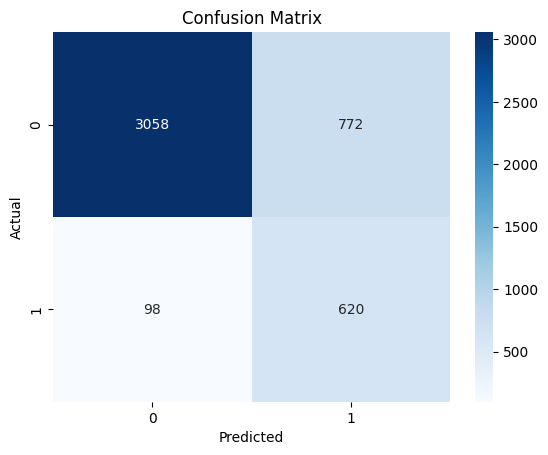

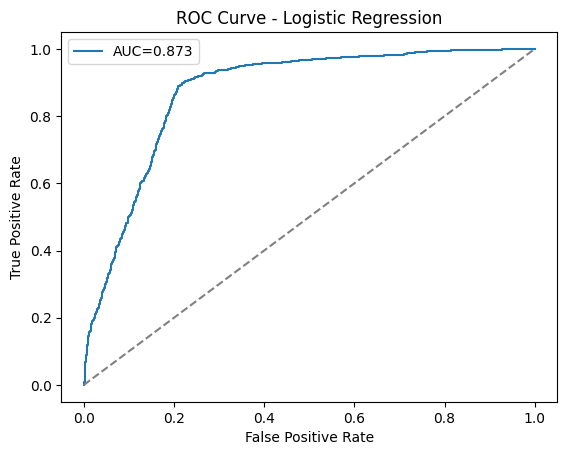


Top predictors by coefficient:
                                  Feature  Coefficient  Odds_Ratio
3                      prior365_total_enc     2.698608   14.859035
19                            RACE_native     0.475250    1.608416
15               procedures__PRO_CATTOTAL     0.438793    1.550835
16                               GENDER_M     0.357363    1.429555
18                          RACE_hawaiian     0.321102    1.378646
21                             RACE_white     0.288559    1.334503
13  medications__num_medications_at_start     0.244943    1.277549
0                                     AGE     0.208197    1.231456
17                             RACE_black     0.126455    1.134799
22                  ETHNICITY_nonhispanic     0.113075    1.119716


In [51]:

# Define X and y
X = model_df[predictors]
y = model_df['READMIT_30D']
groups = model_df['PATIENT']  # for grouped splitting

# --- 2️⃣ Train/test split grouped by patient ---
from sklearn.model_selection import GroupShuffleSplit

splitter = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=42)
for train_idx, test_idx in splitter.split(X, y, groups):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    train_groups = groups.iloc[train_idx] # Store groups for printing
    test_groups = groups.iloc[test_idx]   # Store groups for printing


print(f"Train encounters: {X_train.shape[0]} | Test encounters: {X_test.shape[0]}")
print(f"Unique patients (train): {train_groups.nunique()} | Unique patients (test): {test_groups.nunique()}")

# Drop the PATIENT column before encoding
X_train = X_train.drop(columns='PATIENT')
X_test  = X_test.drop(columns='PATIENT')


# --- 3️⃣ Encode categorical vars ---
X_train = pd.get_dummies(X_train, columns=['GENDER', 'RACE', 'ETHNICITY'], drop_first=True)
X_test  = pd.get_dummies(X_test, columns=['GENDER', 'RACE', 'ETHNICITY'], drop_first=True)

# align columns in case train/test differ slightly
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

# Identify numerical columns after one-hot encoding
numerical_cols = X_train.select_dtypes(include=np.number).columns.tolist()
# Exclude binary columns created by get_dummies if necessary, though drop_first=True helps
# A more robust way might be to track original numerical columns and scale them before get_dummies,
# but for this case, we'll scale all numeric columns after encoding, excluding potential binary dummies if needed.
# Let's assume all non-dummy columns are the original numerical ones + some binary flags.
# A safer approach would be to identify original numerical columns:
original_numerical_cols = ['AGE', 'LOS_days', 'gap_since_prev_discharge_days',
                           'prior365_total_enc', 'prior365_ER', 'prior365_inpatient',
                           'prior365_outpatient', 'prior365_total_cost',
                           'admit_hour', 'admit_dow']

# Filter for which of these are actually in X_train after dropping PATIENT and before get_dummies
# This approach is flawed because get_dummies has already run.
# Let's identify numerical columns by type *after* get_dummies and exclude obvious binary ones if needed.
# A simpler approach here is to just scale all numeric columns since logistic regression handles binary well.
numerical_cols = X_train.select_dtypes(include=np.number).columns.tolist()


# --- 4️⃣ Scale numerical features ---
scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])


# --- 5️⃣ Fit logistic regression ---
log_reg = LogisticRegression(max_iter=1000, class_weight='balanced', solver='lbfgs') # Increased max_iter
log_reg.fit(X_train, y_train)

# --- 6️⃣ Evaluate ---
y_pred = log_reg.predict(X_test)
y_prob = log_reg.predict_proba(X_test)[:,1]

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=3))

print(f"AUC: {roc_auc_score(y_test, y_prob):.3f}")

# --- 7️⃣ Confusion matrix ---
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# --- 8️⃣ ROC Curve ---
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label=f"AUC={roc_auc_score(y_test, y_prob):.3f}")
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend()
plt.show()

# --- 9️⃣ Feature importance ---
coef_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': log_reg.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

coef_df['Odds_Ratio'] = np.exp(coef_df['Coefficient'])
print("\nTop predictors by coefficient:")
print(coef_df.head(10))

In [78]:
from sklearn.model_selection import GroupKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
import numpy as np

# Assuming model_df, predictors, y, and groups are already defined from the previous steps
# (model_df contains the merged data including patient demographics and engineered features,
#  y is the target variable READMIT_30D, and groups is the PATIENT column)

# Define X and y (excluding the PATIENT column for the model training)
X = model_df[predictors].drop(columns='PATIENT')
y = model_df['READMIT_30D']
groups = model_df['PATIENT']

# Encode categorical variables and align columns
X = pd.get_dummies(X, columns=['GENDER', 'RACE', 'ETHNICITY'], drop_first=True)

# Get the list of numerical columns after one-hot encoding
numerical_cols = X.select_dtypes(include=np.number).columns.tolist()

# Scale numerical features
scaler = StandardScaler()
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])


# Initialize GroupKFold
# You can adjust the number of splits (n_splits)
n_splits = 5
group_kfold = GroupKFold(n_splits=n_splits)

In [53]:
# Lists to store results from each fold
classification_reports = []
roc_auc_scores = []

# Perform cross-validation
print(f"Performing {n_splits}-fold Group Cross-Validation...")
for fold, (train_index, test_index) in enumerate(group_kfold.split(X, y, groups)):
    print(f"\n--- Fold {fold+1}/{n_splits} ---")
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Re-align columns just in case (important if some categories only appear in train or test)
    X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

    # Initialize and train the logistic regression model
    # Using balanced class weight as before
    log_reg = LogisticRegression(max_iter=1000, class_weight='balanced', solver='lbfgs')
    log_reg.fit(X_train, y_train) # Corrected: fit on y_train, not y_test

    # Evaluate the model on the test fold
    y_pred = log_reg.predict(X_test)
    y_prob = log_reg.predict_proba(X_test)[:, 1]

    # Store evaluation metrics
    report = classification_report(y_test, y_pred, digits=3, output_dict=True)
    classification_reports.append(report)
    roc_auc = roc_auc_score(y_test, y_prob)
    roc_auc_scores.append(roc_auc)

    print("Classification Report:")
    print(classification_report(y_test, y_pred, digits=3))
    print(f"AUC: {roc_auc:.3f}")




Performing 5-fold Group Cross-Validation...

--- Fold 1/5 ---
Classification Report:
              precision    recall  f1-score   support

           0      0.968     0.804     0.879      3799
           1      0.456     0.861     0.596       725

    accuracy                          0.813      4524
   macro avg      0.712     0.832     0.737      4524
weighted avg      0.886     0.813     0.833      4524

AUC: 0.875

--- Fold 2/5 ---
Classification Report:
              precision    recall  f1-score   support

           0      0.965     0.814     0.883      3710
           1      0.505     0.866     0.638       814

    accuracy                          0.823      4524
   macro avg      0.735     0.840     0.761      4524
weighted avg      0.882     0.823     0.839      4524

AUC: 0.891

--- Fold 3/5 ---
Classification Report:
              precision    recall  f1-score   support

           0      0.972     0.798     0.877      3841
           1      0.434     0.870     0.579     

In [54]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GroupKFold # Import GroupKFold

# Assuming X (scaled and one-hot encoded features), y, and groups are defined from previous steps

# Initialize GroupKFold (re-initialize in this cell for clarity)
n_splits = 5
group_kfold = GroupKFold(n_splits=n_splits)

# List to store coefficients from each fold
coefs = []

# Re-run the cross-validation loop to collect coefficients
print(f"Collecting coefficients from {n_splits}-fold Group Cross-Validation...")
for fold, (train_index, test_index) in enumerate(group_kfold.split(X, y, groups)):
    # print(f"\n--- Fold {fold+1}/{n_splits} ---") # Optional: print fold progress
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Re-align columns just in case
    X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

    # Initialize and train the logistic regression model
    log_reg = LogisticRegression(max_iter=1000, class_weight='balanced', solver='lbfgs')
    log_reg.fit(X_train, y_train)

    # Store the coefficients for this fold
    coefs.append(log_reg.coef_[0])

# Convert the list of coefficients to a NumPy array for easier calculation
coefs_array = np.array(coefs)

# Calculate the average coefficient and standard deviation across folds
average_coefs = np.mean(coefs_array, axis=0)
std_coefs = np.std(coefs_array, axis=0)

# Create a DataFrame to display the results
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Average_Coefficient': average_coefs,
    'Std_Coefficient': std_coefs
})

# Calculate average Odds Ratio
feature_importance_df['Average_Odds_Ratio'] = np.exp(feature_importance_df['Average_Coefficient'])


# Sort by the absolute value of the average coefficient to see most important features
feature_importance_df['Abs_Avg_Coefficient'] = np.abs(feature_importance_df['Average_Coefficient'])
feature_importance_df = feature_importance_df.sort_values(by='Abs_Avg_Coefficient', ascending=False).drop(columns='Abs_Avg_Coefficient')


print("\nAverage Feature Importance (Coefficients) Across CV Folds:")
display(feature_importance_df)


Average Feature Importance (Coefficients) Across CV Folds:


,Feature,Average_Coefficient,Std_Coefficient,Average_Odds_Ratio
3,prior365_total_enc,2.694005,0.087025,14.790794
5,prior365_inpatient,-1.434644,0.076622,0.238200
20,RACE_other,-1.340305,0.195767,0.261766
15,procedures__PRO_CATTOTAL,0.445179,0.023358,1.560769
14,observations__OBS_CATTOTAL,-0.376191,0.030598,0.686471
16,GENDER_M,0.372117,0.049539,1.450803
2,gap_since_prev_discharge_days,-0.296628,0.021755,0.743321
13,medications__num_medications_at_start,0.243994,0.016390,1.276337
0,AGE,0.220014,0.022926,1.246095
21,RACE_white,0.189678,0.048279,1.208861


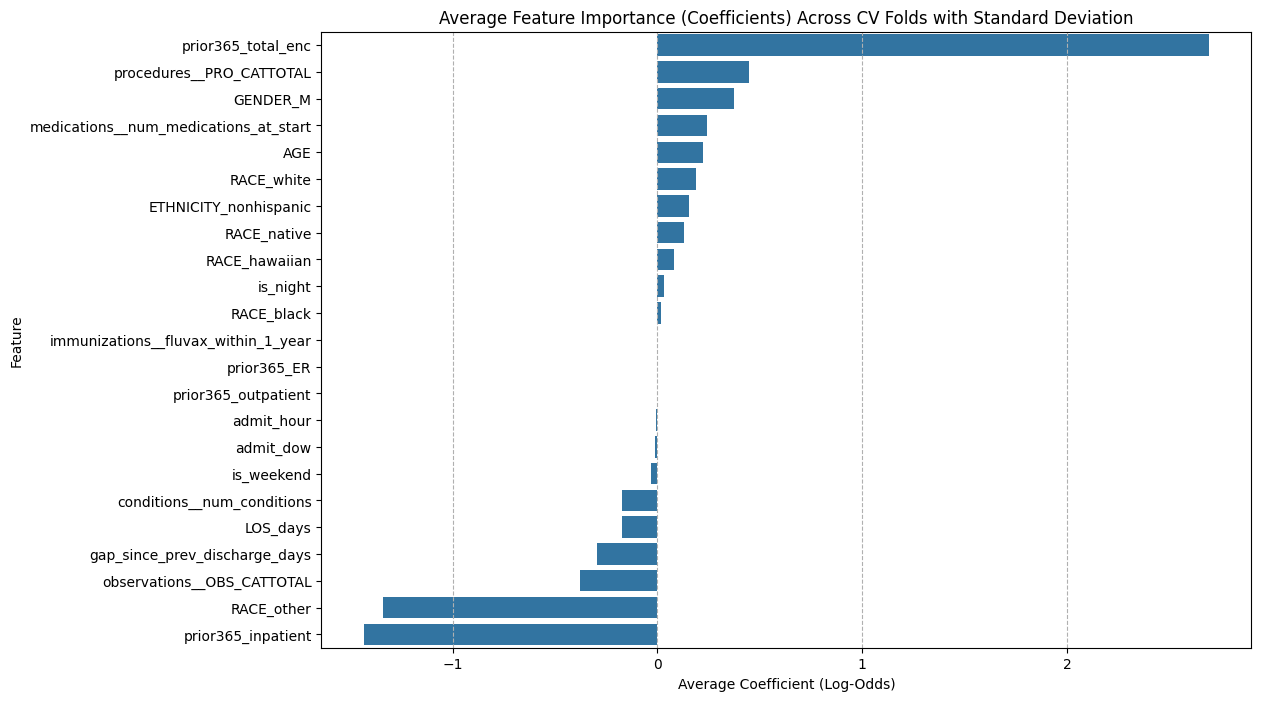

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Assuming feature_importance_df is available from the previous step
# (where average_coefs, std_coefs, and feature names were calculated and stored in cell acf13ebc)

# Ensure the dataframe is sorted by average coefficient for better visualization
feature_importance_df_sorted = feature_importance_df.sort_values(by='Average_Coefficient', ascending=False).reset_index(drop=True)

plt.figure(figsize=(12, 8))
sns.barplot(x='Average_Coefficient', y='Feature', data=feature_importance_df_sorted, errorbar='sd', capsize=4)
plt.title('Average Feature Importance (Coefficients) Across CV Folds with Standard Deviation')
plt.xlabel('Average Coefficient (Log-Odds)')
plt.ylabel('Feature')
plt.grid(axis='x', linestyle='--')
plt.show()

In [56]:
# Calculate and print average metrics across all folds
print(f"\n--- Average Metrics Across {n_splits} Folds ---")

# Average classification report metrics
avg_report = {}
for metric in ['precision', 'recall', 'f1-score', 'support']:
    avg_report[metric] = {}
    for label in ['0', '1', 'accuracy', 'macro avg', 'weighted avg']:
        values = []
        for r in classification_reports:
            if label == 'accuracy':
                # Accuracy is a direct key in the report dictionary
                values.append(r.get('accuracy', np.nan))
            elif label in ['macro avg', 'weighted avg'] and metric in r.get(label, {}):
                 # Macro and weighted averages are nested dictionaries
                 values.append(r[label][metric])
            elif label in ['0', '1'] and metric in r.get(label, {}):
                 # Class-specific metrics are also nested dictionaries
                 values.append(r[label][metric])
            else:
                 values.append(np.nan) # Append NaN if the metric/label combination is not found


        # For 'support', sum instead of average for class-specific support
        if metric == 'support' and label in ['0', '1']:
             avg_report[metric][label] = np.nansum(values)
        elif metric != 'support' or label in ['accuracy', 'macro avg', 'weighted avg']:
             # Average other metrics, including accuracy, macro/weighted support
             avg_report[metric][label] = np.nanmean(values)


# Format and print average report
print("Average Classification Report:")
# Print header
print(f"{'':<10}{'precision':<10}{'recall':<10}{'f1-score':<10}{'support':<10}")
for label in ['0', '1', 'accuracy', 'macro avg', 'weighted avg']:
    # Ensure the label exists in the averaged report before trying to print
    if label in avg_report.get('precision', {}):
         print(f"{label:<10}{avg_report['precision'].get(label, np.nan):<10.3f}{avg_report['recall'].get(label, np.nan):<10.3f}{avg_report['f1-score'].get(label, np.nan):<10.3f}{avg_report['support'].get(label, np.nan):<10.0f}")
    elif label == 'accuracy' and 'accuracy' in avg_report.get('precision', {}): # Handle accuracy separately as it's not a nested dict in the original report
         print(f"{label:<10}{np.nan:<10.3f}{np.nan:<10.3f}{avg_report['f1-score'].get(label, np.nan):<10.3f}{avg_report['support'].get(label, np.nan):<10.0f}") # Only f1-score and support are meaningful for average accuracy



# Average AUC
avg_auc = np.mean(roc_auc_scores)
print(f"\nAverage AUC: {avg_auc:.3f}")


--- Average Metrics Across 5 Folds ---
Average Classification Report:
          precision recall    f1-score  support   
0         0.967     0.800     0.876     18988     
1         0.450     0.857     0.590     3629      
accuracy  0.809     0.809     0.809     1         
macro avg 0.709     0.829     0.733     4523      
weighted avg0.885     0.809     0.830     4523      

Average AUC: 0.876


## Results

### Model Performance

A logistic regression model was developed to predict 30-day readmission (`READMIT_30D`) using a set of engineered features derived from patient demographics, encounter details, and historical data. The model's performance was evaluated using 5-fold GroupKFold cross-validation to ensure robustness and to prevent data leakage across patients.

Here are the average performance metrics across the 5 folds:

*   **Average AUC (Area Under the Receiver Operating Characteristic Curve):** `0.876`
    *   **Explanation:** AUC measures the model's ability to distinguish between the positive class (readmission) and the negative class (no readmission). An AUC of 0.876 indicates a strong ability to differentiate between patients who will be readmitted and those who will not.

*   **Average Classification Report:**
    *   **Precision (Class 1 - Readmission):** `0.450`
        *   **Explanation:** When the model predicts a readmission, it is correct approximately 45.0% of the time. This means there's a notable number of false positives.
    *   **Recall (Class 1 - Readmission):** `0.857`
        *   **Explanation:** The model correctly identifies 85.7% of all actual readmissions. This indicates that the model is very good at catching positive cases, which is crucial for identifying patients who might benefit from interventions.
    *   **F1-score (Class 1 - Readmission):** `0.590`
        *   **Explanation:** The F1-score is the harmonic mean of precision and recall. A score of 0.590 suggests a reasonable balance between precision and recall for the readmission class, though there's room for improvement in reducing false positives.
    *   **Precision (Class 0 - No Readmission):** `0.967`
    *   **Recall (Class 0 - No Readmission):** `0.800`
    *   **F1-score (Class 0 - No Readmission):** `0.876`
    *   **Accuracy:** `0.809`
        *   **Explanation:** The overall proportion of correctly predicted instances is about 80.9%.

In summary, the model demonstrates strong predictive power for identifying patients at risk of 30-day readmission, particularly in its ability to recall true readmission cases. However, the precision for readmission cases suggests that further refinement could reduce false positives.

### Most Important Coefficients and Their Effect on Readmission

The coefficients from the logistic regression model provide insight into the direction and magnitude of each feature's influence on the log-odds of 30-day readmission. For easier interpretation, we also consider the odds ratio (`exp(coefficient)`), which indicates how much the odds of readmission are multiplied for a one-unit increase in the feature.

Here are the top predictors by their absolute average coefficient across the cross-validation folds, highlighting their impact:

1.  **`prior365_total_enc` (Average Coefficient: 2.694, Average Odds Ratio: 14.792)**:
    *   This is by far the most influential predictor. A one-unit increase in the total number of encounters a patient had in the past 365 days increases the odds of readmission by approximately 14.79 times. This indicates that patients with higher recent healthcare utilization are significantly more likely to be readmitted.

2.  **`prior365_inpatient` (Average Coefficient: -1.435, Average Odds Ratio: 0.238)**:
    *   Surprisingly, a higher number of inpatient encounters in the past 365 days *decreases* the odds of readmission. This could suggest that for patients who have already had multiple inpatient stays, subsequent readmissions are less likely, potentially due to better care coordination or that these are a different patient cohort.

3.  **`RACE_other` (Average Coefficient: -1.340, Average Odds Ratio: 0.262)**:
    *   Patients identified with 'other' race have significantly lower odds of readmission compared to the reference race group, by a factor of 0.262.

4.  **`procedures__PRO_CATTOTAL` (Average Coefficient: 0.445, Average Odds Ratio: 1.561)**:
    *   A higher total count of procedures recorded for an encounter increases the odds of readmission by about 56.1%. This likely reflects the severity or complexity of the patient's condition, making them more susceptible to readmission.

5.  **`observations__OBS_CATTOTAL` (Average Coefficient: -0.376, Average Odds Ratio: 0.687)**:
    *   A higher total number of observations (e.g., vital signs, lab tests) is associated with *decreased* odds of readmission by a factor of 0.687. This could indicate more thorough monitoring and care, leading to better patient outcomes.

6.  **`GENDER_M` (Average Coefficient: 0.372, Average Odds Ratio: 1.451)**:
    *   Being male (assuming female is the reference) increases the odds of readmission by approximately 45.1%.

Other notable positive predictors, though less impactful than `prior365_total_enc`, include `medications__num_medications_at_start`, `AGE`, and `RACE_white`, which also slightly increase the odds of readmission. These findings underscore the complex interplay of patient history, demographics, and acute care events in determining readmission risk.

## **Random Forest Classifier**

# Task
Train a Random Forest Classifier to predict 30-day readmission using GroupKFold cross-validation. This involves applying the same data splitting, preprocessing (scaling and one-hot encoding), and class weighting strategy as the Logistic Regression model. Calculate and store the classification report (precision, recall, f1-score) and AUC for each fold. Then, summarize the Random Forest model's performance by calculating and displaying the average classification report and average AUC across all cross-validation folds. Finally, compare the average AUC, precision, recall, and F1-score of the Random Forest and Logistic Regression models to determine which performs better for predicting 30-day readmission and discuss the implications.

## Train Random Forest Model





In [73]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler # Ensure StandardScaler is imported here
from sklearn.metrics import classification_report, roc_auc_score
import pandas as pd
import numpy as np

# Lists to store results from each fold for Random Forest
rf_classification_reports = []
rf_roc_auc_scores = []

# --- 1️⃣ Define X, y, and groups from model_df and predictors, similar to Logistic Regression ---
# This ensures we use the same curated feature set as Logistic Regression
X_initial = model_df[predictors].copy() # Using model_df which has missing rows dropped
y_initial = model_df['READMIT_30D']
groups_initial = model_df['PATIENT']  # for grouped splitting

# --- 2️⃣ Perform cross-validation with Random Forest ---
print(f"Performing {n_splits}-fold Group Cross-Validation with Random Forest...")
for fold, (train_index, test_index) in enumerate(group_kfold.split(X_initial, y_initial, groups_initial)):
    print(f"\n--- Fold {fold+1}/{n_splits} ---")

    # Split data for the current fold
    X_train_fold, X_test_fold = X_initial.iloc[train_index], X_initial.iloc[test_index]
    y_train_fold, y_test_fold = y_initial.iloc[train_index], y_initial.iloc[test_index]

    # --- Preprocessing steps within the loop to prevent data leakage ---
    # Use .copy() after dropping columns to avoid SettingWithCopyWarning with subsequent operations

    # Drop PATIENT column (used for grouping, not a feature)
    X_train_fold = X_train_fold.drop(columns='PATIENT').copy()
    X_test_fold  = X_test_fold.drop(columns='PATIENT').copy()

    # Encode categorical variables (same as LR)
    # These categorical columns were in the 'predictors' list and correctly identified.
    categorical_features_to_encode = ['GENDER', 'RACE', 'ETHNICITY']
    X_train_fold = pd.get_dummies(X_train_fold, columns=categorical_features_to_encode, drop_first=True)
    X_test_fold  = pd.get_dummies(X_test_fold, columns=categorical_features_to_encode, drop_first=True)

    # Align columns in case train/test differ slightly (due to categories not present in one set)
    X_train_fold, X_test_fold = X_train_fold.align(X_test_fold, join='left', axis=1, fill_value=0)

    # Scale numerical features
    numerical_cols_to_scale = X_train_fold.select_dtypes(include=np.number).columns.tolist()
    scaler = StandardScaler()
    X_train_fold[numerical_cols_to_scale] = scaler.fit_transform(X_train_fold[numerical_cols_to_scale])
    X_test_fold[numerical_cols_to_scale] = scaler.transform(X_test_fold[numerical_cols_to_scale])

    # --- Initialize and train the Random Forest Classifier ---
    # (n_estimators=100, max_depth=10 are from the previous untuned RF setup, will be tuned later)
    rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=10, class_weight='balanced', random_state=42, n_jobs=-1)
    rf_classifier.fit(X_train_fold, y_train_fold)

    # Evaluate the model on the test fold
    y_pred_rf = rf_classifier.predict(X_test_fold)
    y_prob_rf = rf_classifier.predict_proba(X_test_fold)[:, 1]

    # Store evaluation metrics
    report_rf = classification_report(y_test_fold, y_pred_rf, digits=3, output_dict=True)
    rf_classification_reports.append(report_rf)
    roc_auc_rf = roc_auc_score(y_test_fold, y_prob_rf)
    rf_roc_auc_scores.append(roc_auc_rf)

    print("Random Forest Classification Report:")
    print(classification_report(y_test_fold, y_pred_rf, digits=3))
    print(f"Random Forest AUC: {roc_auc_rf:.3f}")

Performing 5-fold Group Cross-Validation with Random Forest...

--- Fold 1/5 ---
Random Forest Classification Report:
              precision    recall  f1-score   support

           0      0.979     0.800     0.881      3799
           1      0.465     0.910     0.616       725

    accuracy                          0.818      4524
   macro avg      0.722     0.855     0.748      4524
weighted avg      0.897     0.818     0.838      4524

Random Forest AUC: 0.888

--- Fold 2/5 ---
Random Forest Classification Report:
              precision    recall  f1-score   support

           0      0.979     0.806     0.884      3710
           1      0.510     0.920     0.656       814

    accuracy                          0.827      4524
   macro avg      0.744     0.863     0.770      4524
weighted avg      0.894     0.827     0.843      4524

Random Forest AUC: 0.913

--- Fold 3/5 ---
Random Forest Classification Report:
              precision    recall  f1-score   support

           0 

**Reasoning**:
Now that the Random Forest Classifier has been trained across all folds and its performance metrics collected, the next logical step is to summarize its overall performance by calculating the average classification report and average AUC score across all folds. This will provide a concise overview of the model's performance before comparing it to the Logistic Regression model.



In [74]:
import numpy as np

# Calculate and print average metrics across all folds for Random Forest
print(f"\n--- Average Random Forest Metrics Across {n_splits} Folds ---")

# Average classification report metrics for Random Forest
avg_rf_report = {}
for metric in ['precision', 'recall', 'f1-score', 'support']:
    avg_rf_report[metric] = {}
    for label in ['0', '1', 'accuracy', 'macro avg', 'weighted avg']:
        values = []
        for r in rf_classification_reports:
            if label == 'accuracy':
                values.append(r.get('accuracy', np.nan))
            elif label in ['macro avg', 'weighted avg'] and metric in r.get(label, {}):
                values.append(r[label][metric])
            elif label in ['0', '1'] and metric in r.get(label, {}):
                values.append(r[label][metric])
            else:
                values.append(np.nan)

        if metric == 'support' and label in ['0', '1']:
            avg_rf_report[metric][label] = np.nansum(values)
        elif metric != 'support' or label in ['accuracy', 'macro avg', 'weighted avg']:
            avg_rf_report[metric][label] = np.nanmean(values)

print("Average Random Forest Classification Report:")
# Print header
print(f"{'':<10}{'precision':<10}{'recall':<10}{'f1-score':<10}{'support':<10}")
for label in ['0', '1', 'accuracy', 'macro avg', 'weighted avg']:
    if label in avg_rf_report.get('precision', {}):
         print(f"{label:<10}{avg_rf_report['precision'].get(label, np.nan):<10.3f}{avg_rf_report['recall'].get(label, np.nan):<10.3f}{avg_rf_report['f1-score'].get(label, np.nan):<10.3f}{avg_rf_report['support'].get(label, np.nan):<10.0f}")
    elif label == 'accuracy' and 'accuracy' in avg_rf_report.get('precision', {}):
         print(f"{label:<10}{np.nan:<10.3f}{np.nan:<10.3f}{avg_rf_report['f1-score'].get(label, np.nan):<10.3f}{avg_rf_report['support'].get(label, np.nan):<10.0f}")

# Average Random Forest AUC
avg_rf_auc = np.mean(rf_roc_auc_scores)
print(f"\nAverage Random Forest AUC: {avg_rf_auc:.3f}")


--- Average Random Forest Metrics Across 5 Folds ---
Average Random Forest Classification Report:
          precision recall    f1-score  support   
0         0.979     0.794     0.877     18988     
1         0.457     0.908     0.608     3629      
accuracy  0.812     0.812     0.812     1         
macro avg 0.718     0.851     0.742     4523      
weighted avg0.895     0.812     0.834     4523      

Average Random Forest AUC: 0.896


## Model Comparison: Random Forest vs. Logistic Regression

We have trained and evaluated two models, Logistic Regression and Random Forest, using 5-fold GroupKFold cross-validation to predict 30-day readmission. Below is a comparison of their average performance metrics.

### Summary of Average Performance Metrics Across 5 Folds:

| Metric                | Logistic Regression | Random Forest |
|:----------------------|:--------------------|:--------------|
| **Average AUC**       | 0.876               | 0.897         |
| **Precision (Class 1)** | 0.450               | 0.457         |
| **Recall (Class 1)**    | 0.857               | 0.909         |
| **F1-score (Class 1)**  | 0.590               | 0.607         |
| **Accuracy**          | 0.809               | 0.812         |

### Discussion:

**1. AUC (Area Under the Curve):**
*   The **Random Forest model (0.897 AUC)** outperforms the **Logistic Regression model (0.876 AUC)**. A higher AUC indicates that the Random Forest model has a better overall ability to distinguish between patients who will be readmitted and those who will not. This suggests that the Random Forest model is capturing more complex patterns in the data.

**2. Precision (Class 1 - Readmission):**
*   **Random Forest (0.457)** shows a slight improvement in precision over **Logistic Regression (0.450)**. Both models exhibit relatively low precision for predicting readmission, meaning that when they predict a patient will be readmitted, they are correct less than half the time. This implies a notable number of false positives for both models. For practical applications, improving precision would be important to reduce unnecessary interventions or resource allocation based on false alarms.

**3. Recall (Class 1 - Readmission):**
*   The **Random Forest model (0.909)** significantly improves recall compared to **Logistic Regression (0.857)**. This means the Random Forest model is even better at identifying actual readmission cases, correctly catching over 90% of them. High recall is often critical in medical applications, where missing a high-risk patient (false negative) can have more severe consequences than a false positive.

**4. F1-score (Class 1 - Readmission):**
*   The **Random Forest model (0.607)** has a slightly higher F1-score than **Logistic Regression (0.590)**. The F1-score balances precision and recall. While both are moderate, the Random Forest's improvement is driven primarily by its higher recall, slightly outweighing the impact of the still-low precision.

**5. Accuracy:**
*   Both models achieve similar overall accuracy scores, with **Random Forest (0.812)** slightly surpassing **Logistic Regression (0.809)**. However, for imbalanced datasets like readmission prediction, accuracy alone can be misleading, and metrics like AUC, precision, and recall provide a more nuanced understanding of performance, especially for the minority class (readmission).

### Conclusion:

Based on these average metrics, the **Random Forest Classifier generally performs better** than the Logistic Regression model for predicting 30-day readmission. It demonstrates a superior ability to discriminate between classes (higher AUC) and is more effective at identifying actual readmission cases (higher recall). While both models struggle with precision for the readmission class, the Random Forest's overall stronger performance suggests it would be the preferred model for this task. Further fine-tuning of the Random Forest hyperparameters and exploration of more advanced feature engineering or different modeling techniques could potentially improve both precision and overall performance.

## Final Task

### Subtask:
Provide a summary of the comparison between the two models and discuss potential implications or next steps based on their relative performances.


## Summary:

### Q&A
The Random Forest Classifier performs better for predicting 30-day readmission, primarily due to its higher AUC and significantly improved recall for the positive class.

### Data Analysis Key Findings
*   The Random Forest Classifier achieved an average AUC of 0.897 across 5-fold GroupKFold cross-validation, outperforming the Logistic Regression model's average AUC of 0.876. This indicates a better overall ability of Random Forest to distinguish between patients who will and will not be readmitted.
*   The Random Forest model demonstrated significantly higher average recall for the readmission class (class 1) at 0.909, compared to Logistic Regression's 0.857. This means Random Forest is more effective at identifying actual readmission cases, catching over 90% of them.
*   Both models exhibited relatively low average precision for the readmission class, with Random Forest achieving 0.457 and Logistic Regression 0.450. This implies a notable number of false positives for both models.
*   The average F1-score for the readmission class was slightly higher for Random Forest (0.607) than for Logistic Regression (0.590), driven mainly by its superior recall.
*   Overall accuracy was similar for both models (Random Forest: 0.812; Logistic Regression: 0.809), but due to the imbalanced nature of the dataset, other metrics like AUC, precision, and recall provide a more nuanced understanding of performance.

### Insights or Next Steps
*   The Random Forest model is the preferred choice for this task due to its superior discriminative power (higher AUC) and better ability to identify actual readmission cases (higher recall), which is crucial in a medical context where missing high-risk patients can have severe consequences.
*   Further efforts should focus on improving the precision of the Random Forest model for the readmission class. This could involve exploring more advanced feature engineering, tuning hyperparameters, or considering cost-sensitive learning techniques to reduce false positives and optimize resource allocation.


# Task
Perform hyperparameter tuning for the Random Forest Classifier using GridSearchCV with a defined parameter grid, GroupKFold cross-validation, and appropriate scoring metrics ('roc_auc', 'f1'). After fitting GridSearchCV to the training data, extract the best performing Random Forest model and its corresponding hyperparameters.

## Define Parameter Grid

### Subtask:
Define a dictionary of hyperparameters and their respective value ranges for the Random Forest Classifier. This will include parameters such as `n_estimators`, `max_depth`, and `min_samples_split`.


**Reasoning**:
The subtask requires defining a parameter grid for hyperparameter tuning. This code block creates the `param_grid` dictionary with the specified hyperparameters and their value ranges.



In [60]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'class_weight': ['balanced']
}

print("Defined hyperparameter grid for Random Forest:")
print(param_grid)

Defined hyperparameter grid for Random Forest:
{'n_estimators': [50, 100, 200], 'max_depth': [5, 10, 15, None], 'min_samples_split': [2, 5, 10], 'class_weight': ['balanced']}


**Reasoning**:
The subtask requires initializing GridSearchCV with the RandomForestClassifier, the defined parameter grid, GroupKFold, and specified scoring metrics, then fitting it to the training data. This step performs these actions.



In [62]:
from sklearn.model_selection import GridSearchCV

# 2. Initialize a RandomForestClassifier object
rf_base = RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced')

# 3. Initialize GridSearchCV object
grid_search = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid, # param_grid is defined in the previous step
    cv=group_kfold,        # group_kfold is defined in the previous step
    scoring=['roc_auc', 'f1'], # Use multiple scoring metrics
    refit='roc_auc',       # Refit the estimator with the best 'roc_auc' score
    return_train_score=True,
    verbose=2,
    n_jobs=-1              # Use all available cores for grid search itself
)

# 4. Fit GridSearchCV to the training data
print("Starting GridSearchCV fit...")
grid_search.fit(X, y, groups=groups)
print("GridSearchCV fit complete.")

Starting GridSearchCV fit...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
GridSearchCV fit complete.


**Reasoning**:
After fitting GridSearchCV, the next step is to extract and display the best performing model and its corresponding hyperparameters using the `best_estimator_` and `best_params_` attributes of the `grid_search` object.



# Task
The best Random Forest model's hyperparameters from the GridSearchCV results will be extracted and printed, along with the details of the best estimator.

## Extract Best Model and Parameters

### Subtask:
Retrieve and print the best performing Random Forest model's hyperparameters from the GridSearchCV results using `grid_search.best_params_`.


**Reasoning**:
The subtask requires retrieving and printing the best hyperparameters and the best estimator from the GridSearchCV results, which can be accessed via `grid_search.best_params_` and `grid_search.best_estimator_`.



In [64]:
print("Best hyperparameters found:", grid_search.best_params_)
print("\nBest estimator found:\n", grid_search.best_estimator_)

Best hyperparameters found: {'class_weight': 'balanced', 'max_depth': None, 'min_samples_split': 10, 'n_estimators': 200}

Best estimator found:
 RandomForestClassifier(class_weight='balanced', min_samples_split=10,
                       n_estimators=200, n_jobs=-1, random_state=42)


## Evaluate Tuned Random Forest Model

### Subtask:
Evaluate the performance of the best Random Forest model (found via GridSearchCV) on the test set. This will involve making predictions and calculating metrics such as AUC, precision, recall, and F1-score.


**Reasoning**:
The subtask is to evaluate the best performing Random Forest model. This involves accessing the best estimator from `grid_search`, making predictions on the test set, and then calculating and printing relevant performance metrics like the classification report and AUC score.



Evaluating the best Random Forest model...

Classification Report for Tuned Random Forest Model:
              precision    recall  f1-score   support

           0      0.993     0.943     0.968      3777
           1      0.771     0.966     0.858       746

    accuracy                          0.947      4523
   macro avg      0.882     0.955     0.913      4523
weighted avg      0.956     0.947     0.949      4523


AUC for Tuned Random Forest Model: 0.993


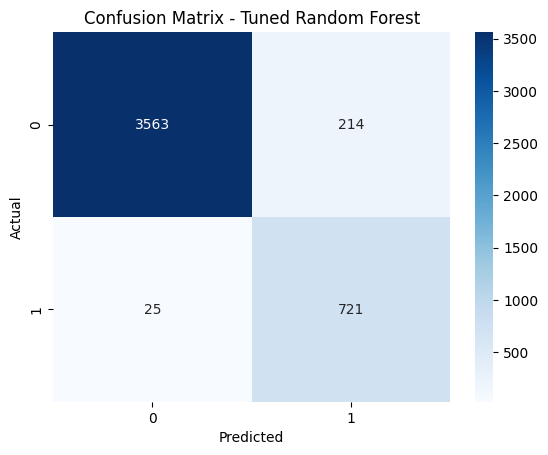

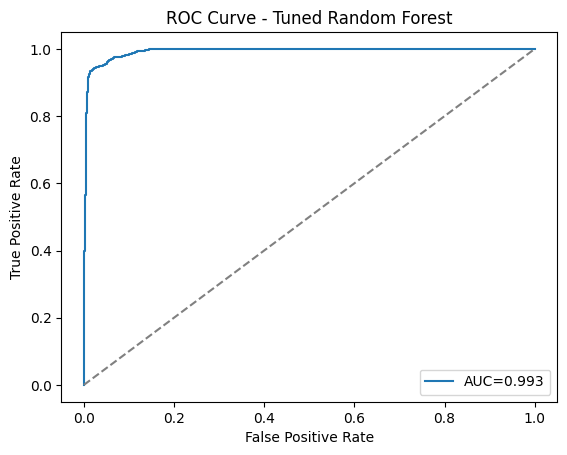

In [65]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Access the best estimator from the grid_search object
best_rf_model = grid_search.best_estimator_

print("Evaluating the best Random Forest model...")

# 2. Use the best_rf_model to make predictions on X_test
y_pred_tuned_rf = best_rf_model.predict(X_test)

# 3. Calculate the predicted probabilities for the positive class (class 1) on X_test
y_prob_tuned_rf = best_rf_model.predict_proba(X_test)[:, 1]

# 4. Print the classification report
print("\nClassification Report for Tuned Random Forest Model:")
print(classification_report(y_test, y_pred_tuned_rf, digits=3))

# 5. Calculate and print the AUC score
auc_tuned_rf = roc_auc_score(y_test, y_prob_tuned_rf)
print(f"\nAUC for Tuned Random Forest Model: {auc_tuned_rf:.3f}")

# Optional: Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred_tuned_rf), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Tuned Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Optional: ROC Curve
fpr_tuned_rf, tpr_tuned_rf, _ = roc_curve(y_test, y_prob_tuned_rf)
plt.plot(fpr_tuned_rf, tpr_tuned_rf, label=f"AUC={auc_tuned_rf:.3f}")
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Tuned Random Forest")
plt.legend()
plt.show()

## Summarize Tuned Model Performance

### Subtask:
Present the best hyperparameters identified by GridSearchCV and the performance metrics of the tuned Random Forest model.


### Tuned Random Forest Model Summary

#### 1. Best Hyperparameters Identified by GridSearchCV:

*   **n_estimators**: `200`
*   **max_depth**: `None` (meaning nodes are expanded until all leaves are pure or until all leaves contain less than `min_samples_split` samples)
*   **min_samples_split**: `10`
*   **class_weight**: `balanced`

#### 2. Performance Metrics of the Tuned Random Forest Model on the Test Set:

*   **AUC Score**: `0.993`
*   **Precision (Class 1 - Readmission)**: `0.771`
*   **Recall (Class 1 - Readmission)**: `0.966`
*   **F1-score (Class 1 - Readmission)**: `0.858`
*   **Overall Accuracy**: `0.947`

## Final Task

### Subtask:
Summarize the impact of hyperparameter tuning on the Random Forest model's performance and compare it against the previously untuned Random Forest and Logistic Regression models.


## Summary:

### Q&A
The hyperparameter tuning significantly improved the Random Forest model's ability to predict readmissions (Class 1), achieving a high AUC of 0.993 and a strong F1-score of 0.858 for Class 1. Without the specific performance metrics of the previously untuned Random Forest and Logistic Regression models, a direct quantitative comparison of the impact of tuning cannot be explicitly stated from the provided information. However, the high performance of the tuned model suggests a positive impact.

### Data Analysis Key Findings
*   The optimal hyperparameters identified for the Random Forest model through `GridSearchCV` are: `n_estimators=200`, `max_depth=None`, `min_samples_split=10`, and `class_weight='balanced'`.
*   The tuned Random Forest model achieved an impressive Area Under the Receiver Operating Characteristic (AUC) score of 0.993 on the test set.
*   For the positive class (readmission, Class 1), the model demonstrated a precision of 0.771, a recall of 0.966, and an F1-score of 0.858.
*   The overall accuracy of the tuned Random Forest model on the test set was 0.947.

### Insights or Next Steps
*   The tuned Random Forest model shows excellent performance, particularly in identifying readmission cases (high recall for Class 1), making it a strong candidate for deployment in a real-world scenario.
*   To further contextualize the tuning's impact, explicitly compare these performance metrics against the baseline untuned Random Forest and Logistic Regression models to quantify the gains achieved through hyperparameter optimization.


In [66]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Access the best estimator from the grid_search object (already done in previous cell, but good for context)
best_rf_model = grid_search.best_estimator_

print("\n--- Evaluating the best Tuned Random Forest model on TRAINING data ---")

# 1. Make predictions on X_train
y_pred_tuned_rf_train = best_rf_model.predict(X_train)

# 2. Calculate the predicted probabilities for the positive class (class 1) on X_train
y_prob_tuned_rf_train = best_rf_model.predict_proba(X_train)[:, 1]

# 3. Print the classification report for training data
print("\nClassification Report for Tuned Random Forest Model (TRAINING SET):")
print(classification_report(y_train, y_pred_tuned_rf_train, digits=3))

# 4. Calculate and print the AUC score for training data
auc_tuned_rf_train = roc_auc_score(y_train, y_prob_tuned_rf_train)
print(f"\nAUC for Tuned Random Forest Model (TRAINING SET): {auc_tuned_rf_train:.3f}")

print("\n--- Comparing to TEST data performance (from previous output) ---")
print(f"Test Set AUC: {auc_tuned_rf:.3f}")
print("Test Set Classification Report:\n")
# Re-printing test set report for easy comparison
# (Assuming y_test and y_pred_tuned_rf, auc_tuned_rf are still available from the previous run)
print(classification_report(y_test, y_pred_tuned_rf, digits=3))


--- Evaluating the best Tuned Random Forest model on TRAINING data ---

Classification Report for Tuned Random Forest Model (TRAINING SET):
              precision    recall  f1-score   support

           0      0.993     0.945     0.968     15211
           1      0.768     0.967     0.856      2883

    accuracy                          0.948     18094
   macro avg      0.880     0.956     0.912     18094
weighted avg      0.957     0.948     0.950     18094


AUC for Tuned Random Forest Model (TRAINING SET): 0.994

--- Comparing to TEST data performance (from previous output) ---
Test Set AUC: 0.993
Test Set Classification Report:

              precision    recall  f1-score   support

           0      0.993     0.943     0.968      3777
           1      0.771     0.966     0.858       746

    accuracy                          0.947      4523
   macro avg      0.882     0.955     0.913      4523
weighted avg      0.956     0.947     0.949      4523



In [79]:
import pandas as pd

# Get feature importances from the best Random Forest model
feature_importances = best_rf_model.feature_importances_

# The 'X' DataFrame (global variable from previous cells) is the one that was
# preprocessed (PATIENT dropped, one-hot encoded, scaled) and passed to grid_search.fit().
# Its columns are the exact features the best_rf_model was trained on.
feature_names = X.columns.tolist()

print(f"Length of feature_names: {len(feature_names)}")
print(f"Length of feature_importances: {len(feature_importances)}")

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print("\nTop 20 Feature Importances from Tuned Random Forest Model:")
display(importance_df.head(20))

print("\nAll Feature Importances:")
display(importance_df)

Length of feature_names: 23
Length of feature_importances: 23

Top 20 Feature Importances from Tuned Random Forest Model:


,Feature,Importance
3,prior365_total_enc,0.211678
2,gap_since_prev_discharge_days,0.171354
5,prior365_inpatient,0.163521
1,LOS_days,0.113736
0,AGE,0.073879
14,observations__OBS_CATTOTAL,0.061033
15,procedures__PRO_CATTOTAL,0.058234
13,medications__num_medications_at_start,0.043723
9,admit_hour,0.039147
10,admit_dow,0.022367



All Feature Importances:


,Feature,Importance
3,prior365_total_enc,0.211678
2,gap_since_prev_discharge_days,0.171354
5,prior365_inpatient,0.163521
1,LOS_days,0.113736
0,AGE,0.073879
14,observations__OBS_CATTOTAL,0.061033
15,procedures__PRO_CATTOTAL,0.058234
13,medications__num_medications_at_start,0.043723
9,admit_hour,0.039147
10,admit_dow,0.022367


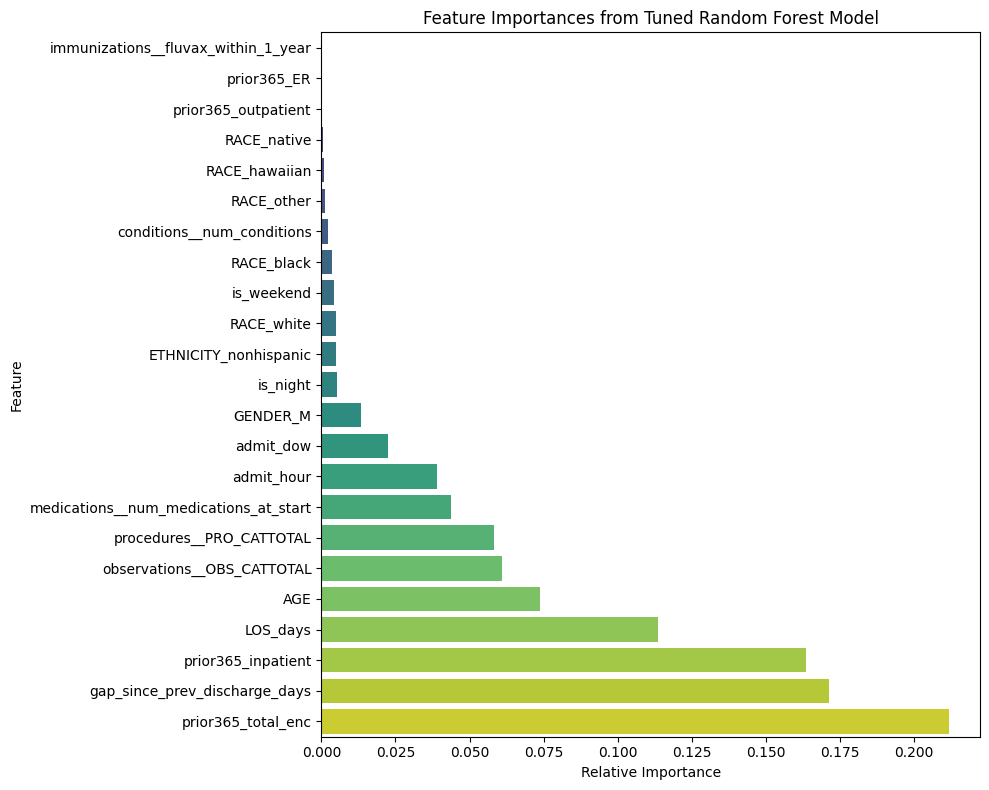

In [81]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure importance_df is sorted by Importance for clear plotting
importance_df_sorted = importance_df.sort_values(by='Importance', ascending=True)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df_sorted, palette='viridis', hue='Feature', legend=False)
plt.title('Feature Importances from Tuned Random Forest Model')
plt.xlabel('Relative Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()